## Development Banks in Mexico

In [19]:
import sys
import os
import pandas as pd
import numpy as np


# For creating cool charts :)
import matplotlib.pyplot as plt
from matplotlib import image
import matplotlib as mpl
from dateutil.relativedelta import relativedelta
from highlight_text import ax_text
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import locale

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

# For dates in spanish
locale.setlocale(locale.LC_ALL,'es_ES')

'es_ES'

## Load fonts

In [20]:
# Load the Comfortaa style

path = [x for x in sys.path if "assets" in x][0] + "\\fonts\\Teko\\"

for x in os.listdir(path):
    if x.split(".")[-1] == "ttf":
        fm.fontManager.addfont(path + "/" + x)
        try:
            fm.FontProperties(weight=x.split(
                "-")[-1].split(".")[0].lower(), fname=x)
        except:
            x

path = [x for x in sys.path if "assets" in x][0] + "\\fonts\\Dosis\\"

for x in os.listdir(path):
    if x.split(".")[-1] == "ttf":
        fm.fontManager.addfont(path + "/" + x)
        try:
            fm.FontProperties(weight=x.split(
                "-")[-1].split(".")[0].lower(), fname=x)
        except:
            x

### Loan Portfolio

In [21]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "institutions"
    ],
    "categories": {
        "institutions": "all"
    },
    "request": [
        {
            "table": "mex_cnbv_db_balance_sheet",
            "variables": [
                "aa9a4f2f8a95db3",
                "b4ea69bfe2b9735"
            ]
        }
    ],
    "from": "2012-01-31"
}

response = get_tukan_api_request(payload)

Success getting the data


In [22]:
data = response["data"].copy()
data[["institutions", "institutions__ref"]].drop_duplicates()

institutions institutions__ref
0                           Banco del Bienestar   0367f650fbf863d
1                  Sociedad Hipotecaria Federal   955887a21812f63
2                          Bancos de desarrollo   a854677b715cbbe
3                   Banco Nacional del Ejército   bcc37ecb9c0ed9f
4                           Nacional Financiera   e3ce30fc7a5c4a0
5  Banco Nacional de Obras y Servicios Públicos   e90ea42a3ead1ca
6           Banco Nacional de Comercio Exterior   ec24ead22c68944

In [23]:
data.fillna(0, inplace = True)
data["total_loans"] = data["aa9a4f2f8a95db3"] + data["b4ea69bfe2b9735"]

data_cons = data[data["institutions__ref"] == "a854677b715cbbe"].copy()
data_banks = data[data["institutions__ref"] != "a854677b715cbbe"].copy()
data_cons.reset_index(drop = True)
data_banks.reset_index(drop = True)
data_cons["yoy_growth"] = data_cons["total_loans"]/data_cons["total_loans"].shift(12) - 1
data_cons.dropna(inplace = True)

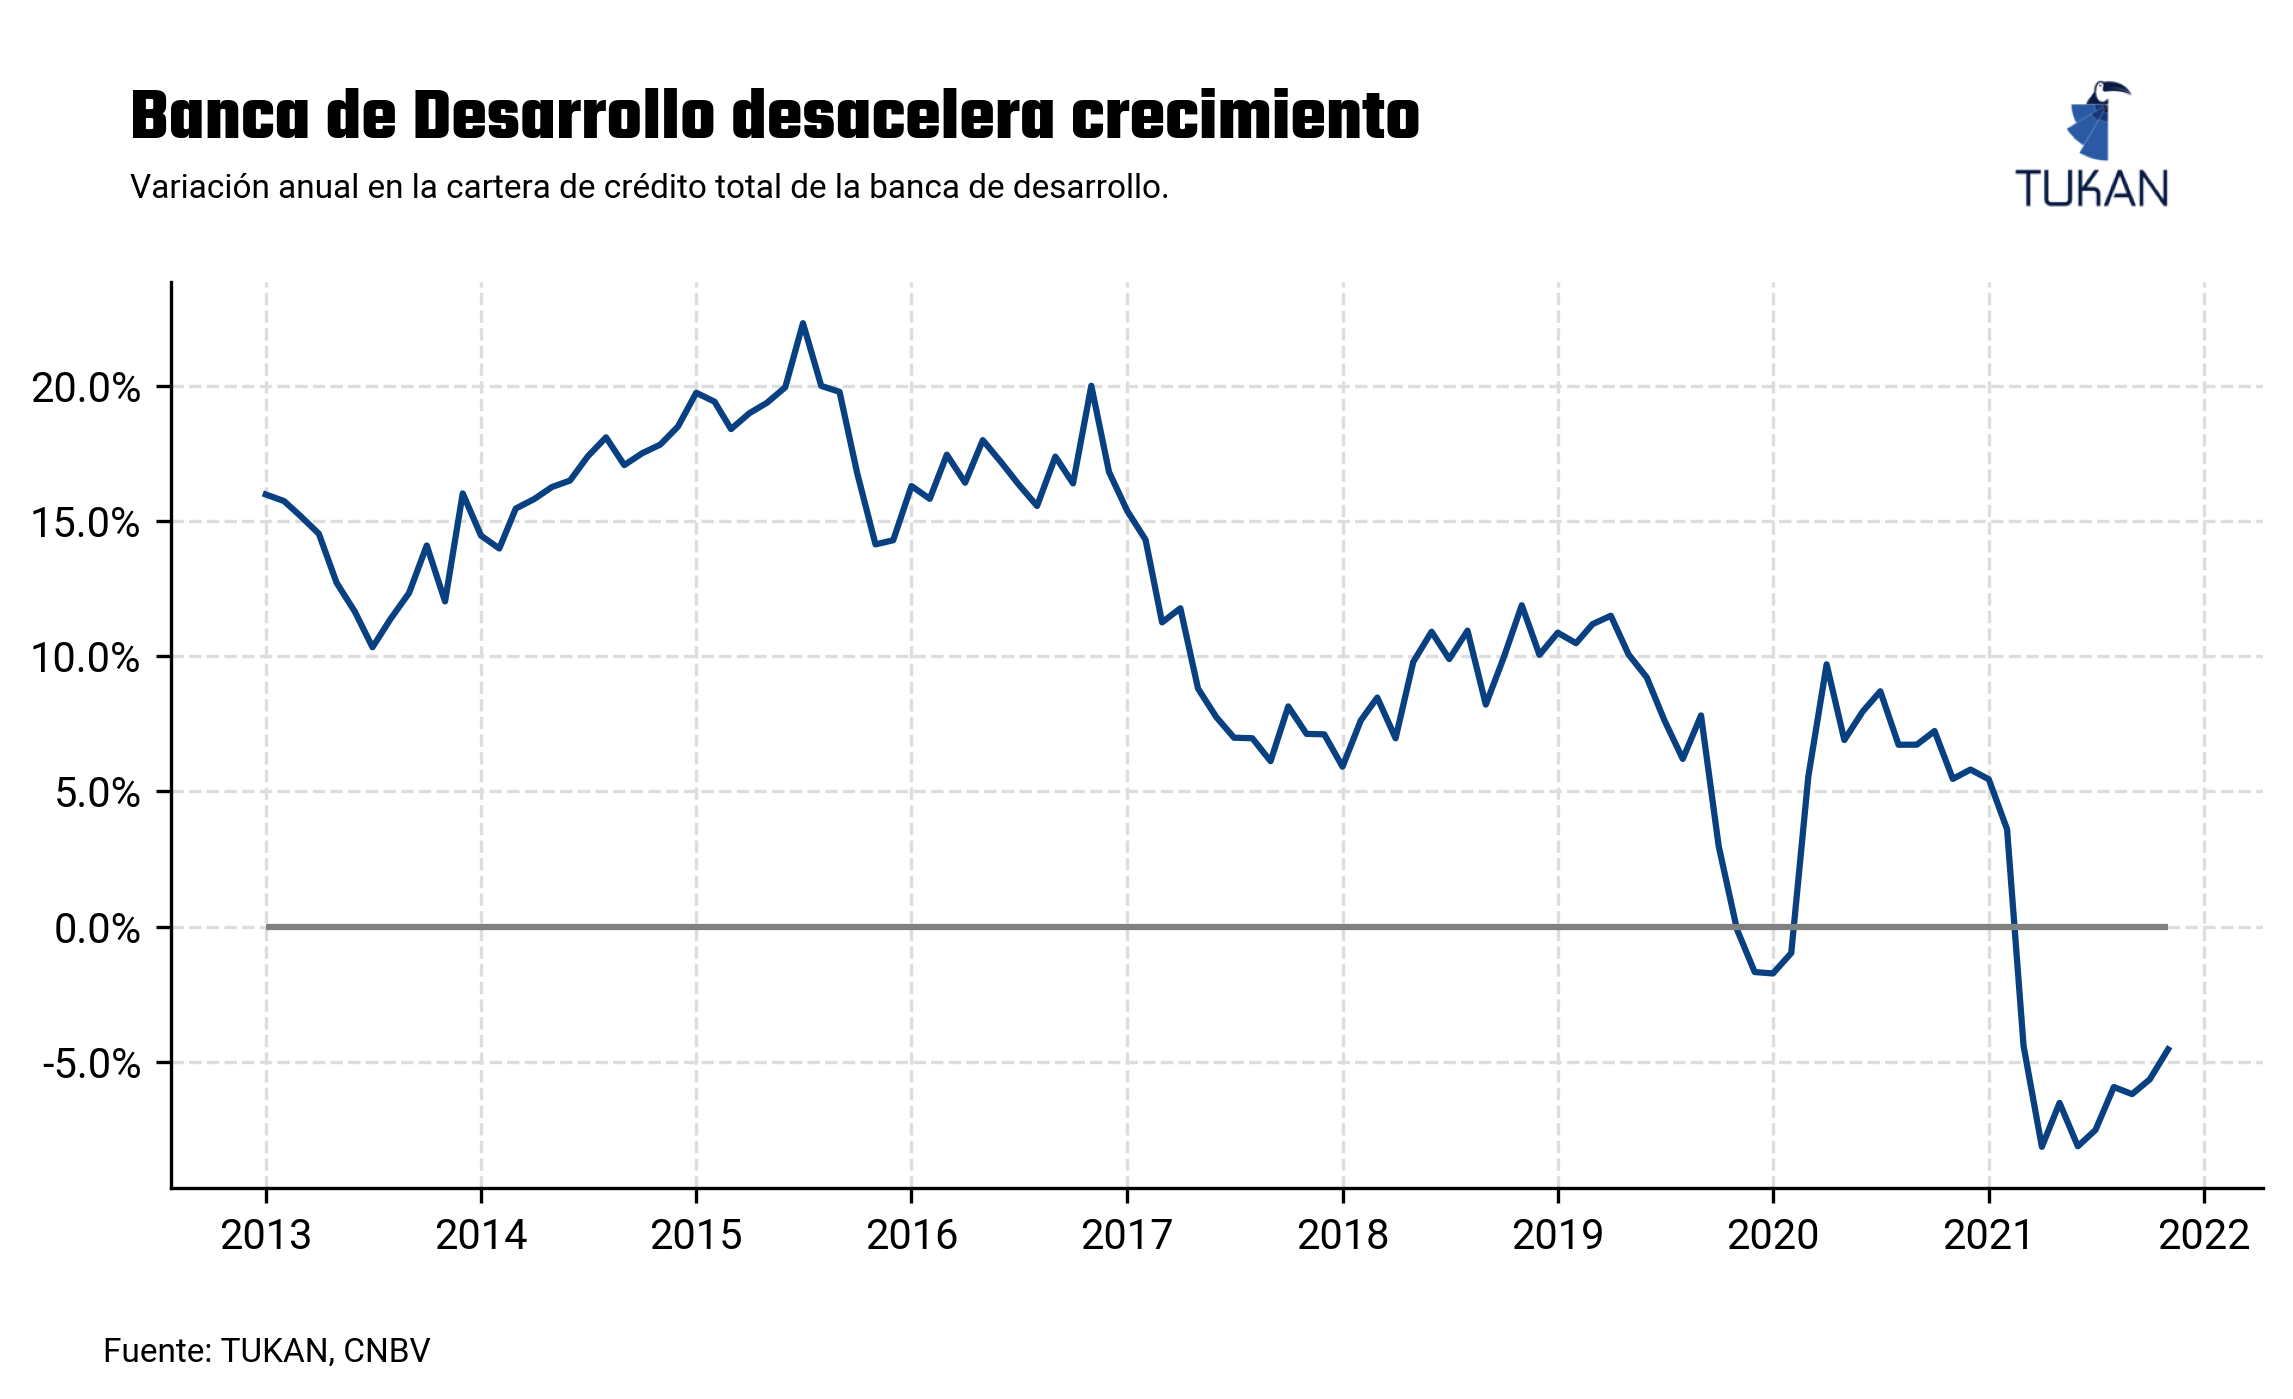

In [24]:
fig = plt.figure(figsize = (9,4), dpi = 300)
ax = plt.subplot(111)

cmap = mpl.cm.get_cmap("GnBu_r", 10)

ax.plot(data_cons["date"], data_cons["yoy_growth"], color = cmap(0))
ax.hlines(y = 0, xmin = data_cons["date"].min(), xmax = data_cons["date"].max(), color = "gray")

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.1%}"))

fig.text(
    0.11,
    1,
    "Banca de Desarrollo desacelera crecimiento",
    size=18,
    weight = "bold",
    font = "Teko"
)

fig.text(
    0.11,
    0.95,
    "Variación anual en la cartera de crédito total de la banca de desarrollo.",
    size=8
)
# Add footer
fig.text(0.1, -0.02, "Fuente: TUKAN, CNBV", fontsize=8)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .9, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")


plt.savefig(
    "plots/loan_growth_yoy.png",
    dpi=300,
    bbox_inches="tight",
    edgecolor="none",
    transparent=True,
)


## Loan growth per bank

In [25]:
data_index = data_banks.copy()
# Set the index to ["date", "institutions", "institutions__ref"]
data_index.set_index(["institutions", "date"], inplace=True)

# # Helper Series - Values of date at index 'day'
s = data_index["total_loans"].xs("2018-01-01", level=1)

# # Divide data_index by helper Series and reset index
data_index["index_loans"] = data_index["total_loans"].div(s, level=0)
data_index["index_loans"] = data_index["index_loans"]*100
data_index.reset_index(inplace = True)


In [26]:
data[["institutions", "institutions__ref"]].drop_duplicates()
data_index.replace({"institutions":{
    "Banco del Bienestar":"Bienestar",
    "Sociedad Hipotecaria Federal": "SHF",
    "Banco Nacional del Ejército": "BANJERCITO",
    "Nacional Financiera": "NAFIN",
    "Banco Nacional de Obras y Servicios Públicos": "BANOBRAS",
    "Banco Nacional de Comercio Exterior": "BANCOMEXT"
}}, inplace = True)

In [27]:
data_index = data_index[data_index["date"] > "2017-12-01"].copy()
sort_banks = data_index[data_index["date"] == data_index["date"].max()].sort_values(by = "total_loans", ascending = False)

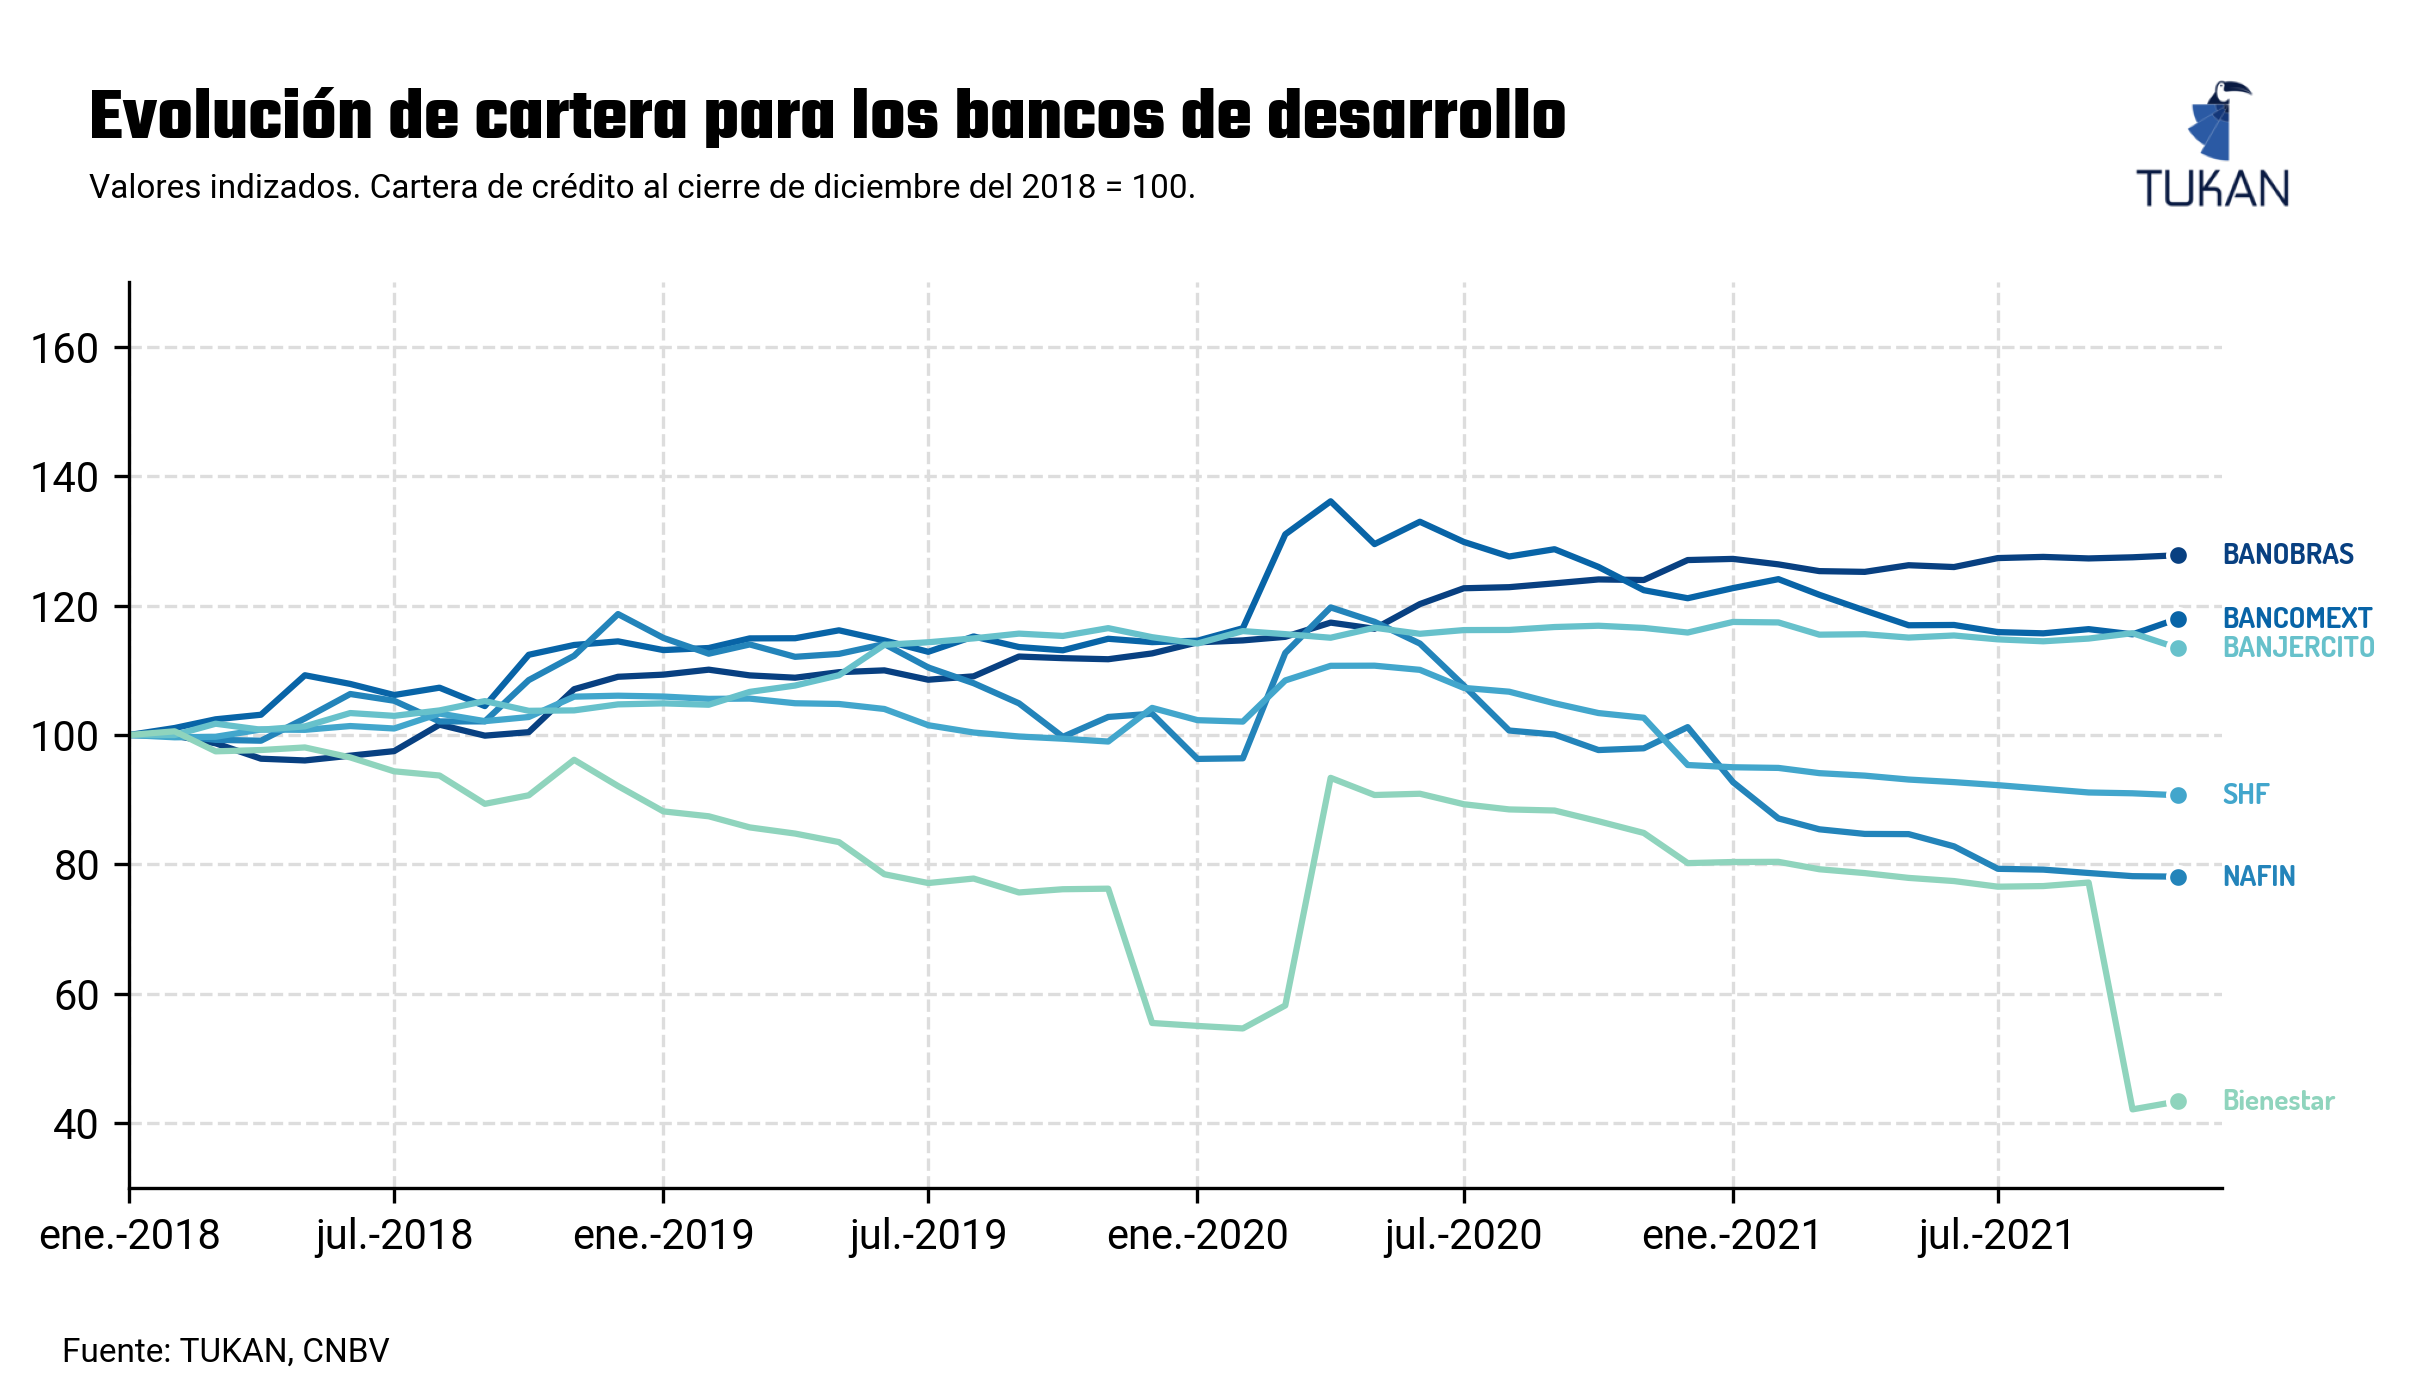

In [37]:
# Global parameters
X_min = data_index["date"].min()
X_max = data_index["date"].max()
center_date = X_min + ((X_max + relativedelta(months=2)) - X_min)/2

fig = plt.figure(figsize = (9,4), dpi = 300)

ax = plt.subplot(111)

banks = list(sort_banks["institutions"].unique())
cmap = mpl.cm.get_cmap("GnBu_r", len(banks) + 4) # So we don't get very light colors

for index, bank in enumerate(banks):
    plot_data_aux = data_index[data_index["institutions"] == bank].copy()
    ax.plot(plot_data_aux["date"], plot_data_aux["index_loans"], marker = "o", markevery = [-1], color = cmap(index), mec = "white", ms = 5)
    Y_end = plot_data_aux["index_loans"].iloc[-1]
    loans_end = plot_data_aux["total_loans"].iloc[-1]
    ax_text(x = X_max + relativedelta(months = 1), y = Y_end + 2,
            s = f"<{bank}>",
            highlight_textprops=[{"color": cmap(index)}], 
                                ax = ax, weight = "bold", font = "Dosis", ha = "left", size = 7)

ax.set_xlim(X_min, X_max + relativedelta(months = 1))
ax.set_ylim(30, 170)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%Y"))


fig.text(
    0.11,
    1,
    "Evolución de cartera para los bancos de desarrollo",
    size=18,
    weight = "bold",
    font = "Teko"
)

fig.text(
    0.11,
    0.95,
    "Valores indizados. Cartera de crédito al cierre de diciembre del 2018 = 100.",
    size=8
)
# Add footer
fig.text(0.1, -0.02, "Fuente: TUKAN, CNBV", fontsize=8)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .9, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")


plt.savefig(
    "plots/loan_growth_banks_white.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=True,
)



### Market Shares

In [29]:
data_mkt_share = data_index[data_index["date"] == data_index["date"].max()].copy()
total_loans_system = data_mkt_share["total_loans"].sum()
data_mkt_share["mkt_share"] = data_mkt_share["total_loans"]/total_loans_system
data_mkt_share = data_mkt_share.sort_values(by = "total_loans", ascending=False)
total_loans_system/1000000/5520553

0.18854749991622216

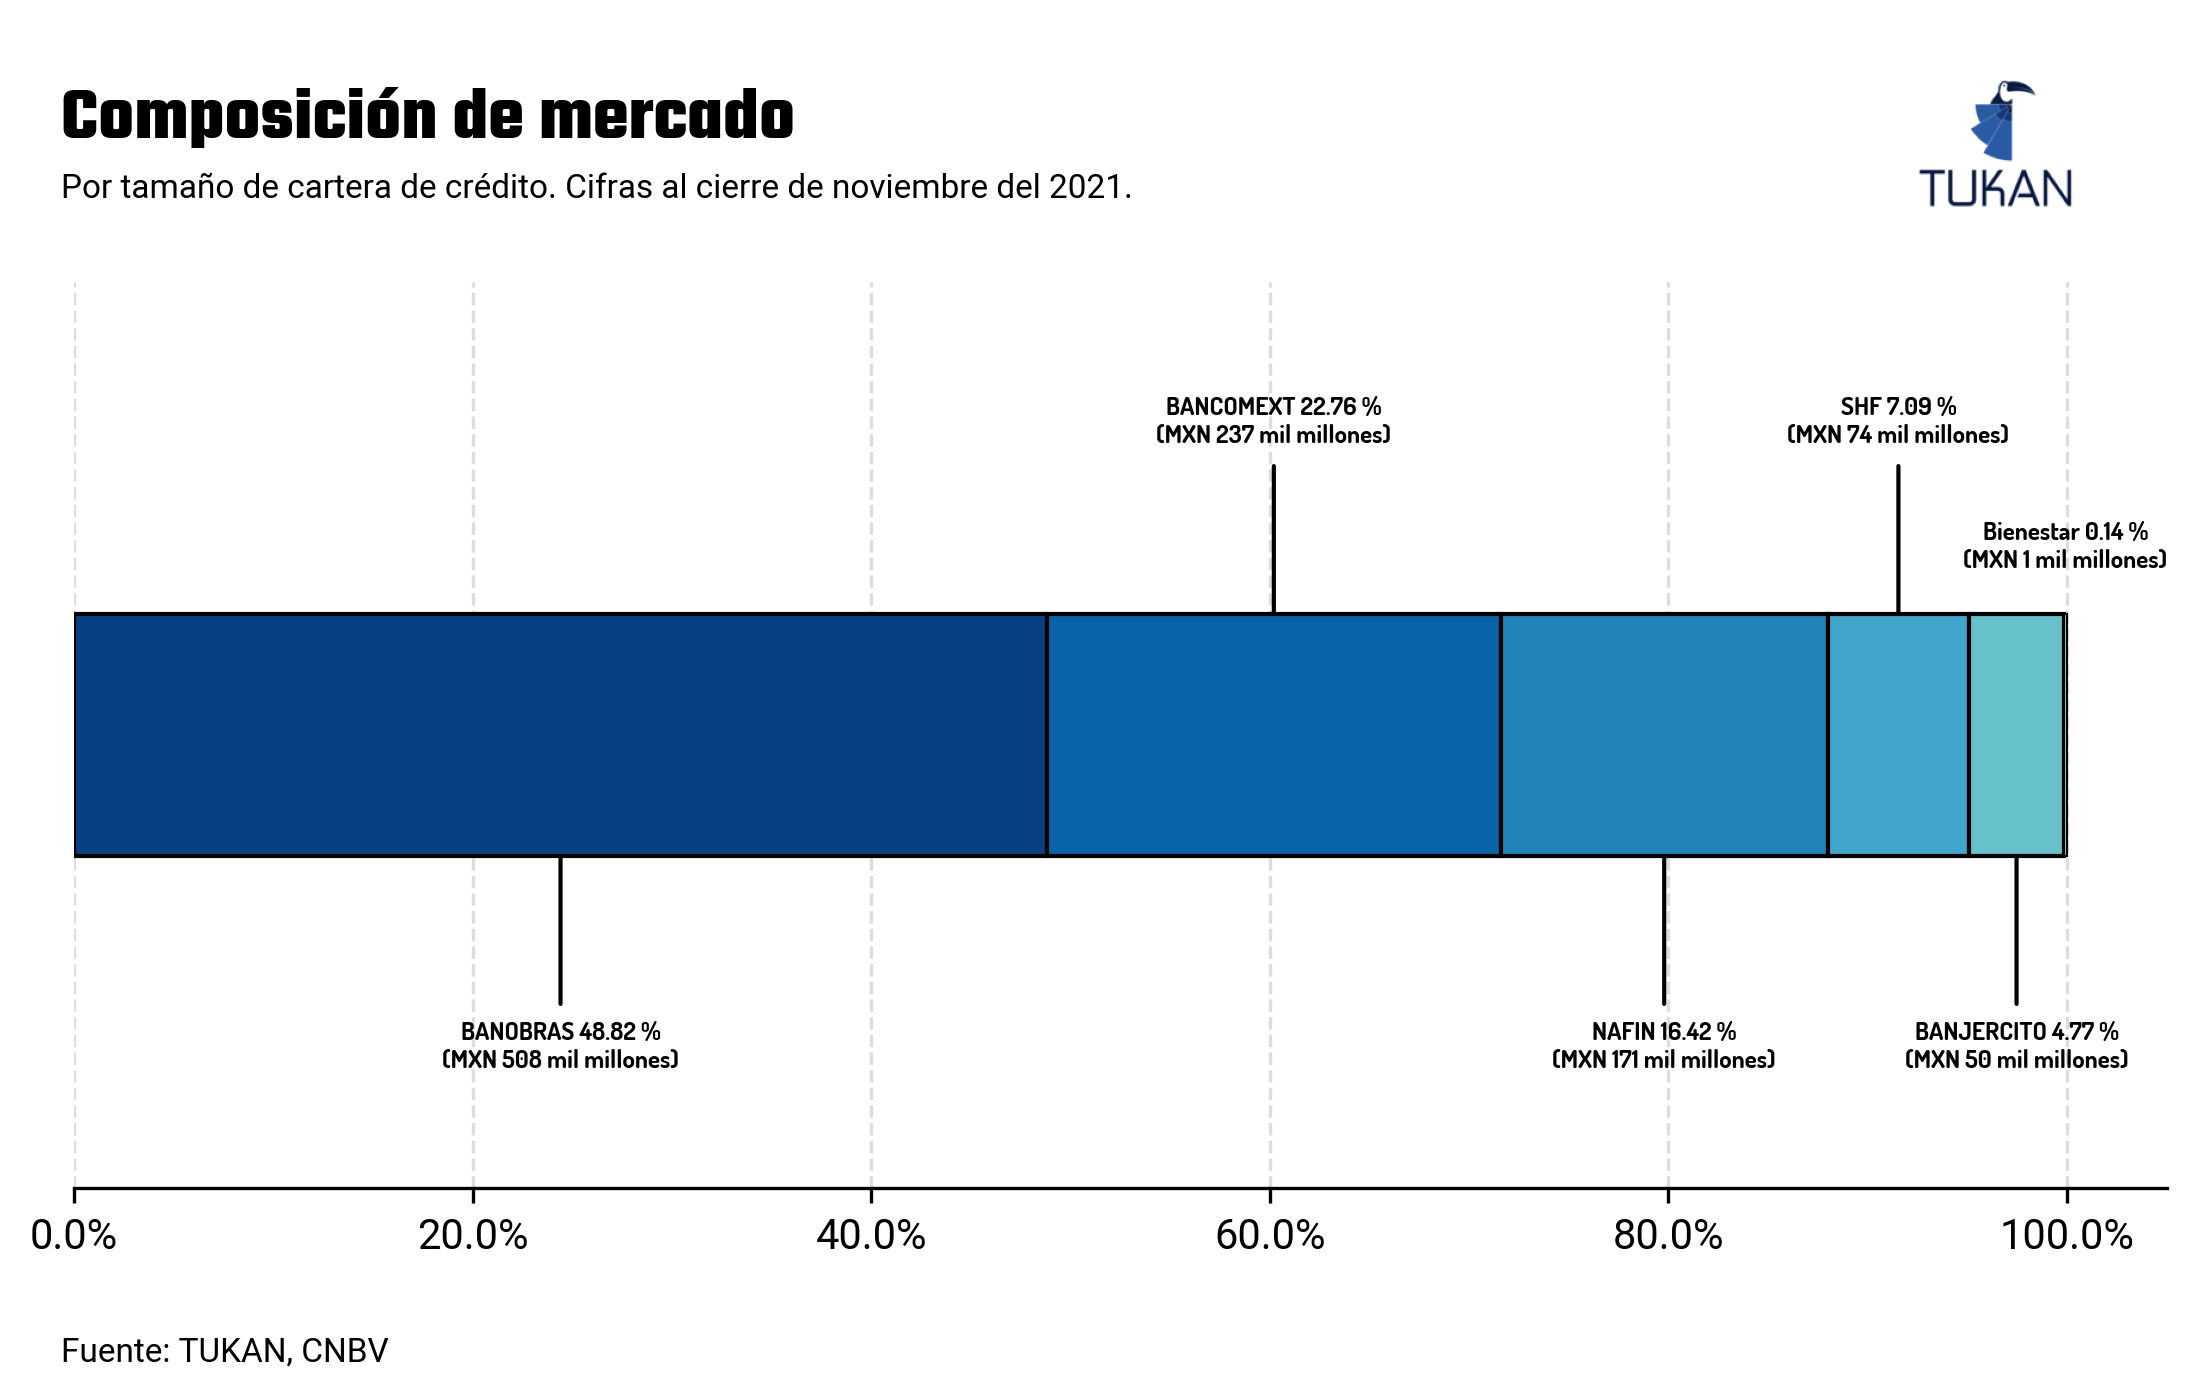

In [30]:
fig = plt.figure(figsize = (9, 4), dpi = 300)
ax = plt.subplot(111)

ax.spines["left"].set_visible(False)
ax.yaxis.set_visible(False)
cmap = mpl.cm.get_cmap("GnBu_r", len(banks) + 4)

left = 0
for index, data in enumerate(data_mkt_share["mkt_share"]):
    institution = data_mkt_share["institutions"].iloc[index]
    cons = data_mkt_share["total_loans"].iloc[index]/1000000000
    if index % 2 == 0:
        mult_aux = -1
    else:
        mult_aux = 1

    if institution == "Bienestar":
        mult_aux_aux = 45
        arrow_dic = None
        edge_width = .5
    else:
        mult_aux_aux = 75
        arrow_dic = dict(
        arrowstyle="->", ec="black", connectionstyle="arc3"
        )
        edge_width = 1
    ax.annotate(
        f"{institution} {round(data*100,2)} %\n(MXN {cons:,.0f} mil millones)",
        xy=(left + data/2, 0),
        xycoords="data",
        xytext=(0, mult_aux*mult_aux_aux),
        textcoords="offset points",
        color="black",
        size=6,
        va="center",
        ha="center",
        weight="bold",
        font = "Dosis",
        arrowprops=arrow_dic,
    )

    ax.barh(0, data, left=left, zorder = 3, ec = "black", color = cmap(index), lw = edge_width)      

    left += data


ax.set_ylim(-1.5,1.5)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1%}'))

fig.text(
    0.12,
    1,
    "Composición de mercado",
    size=18,
    weight = "bold",
    font = "Teko"
)

fig.text(
    0.12,
    0.95,
    "Por tamaño de cartera de crédito. Cifras al cierre de noviembre del 2021.",
    size=8
)
# Add footer
fig.text(0.12, -0.02, "Fuente: TUKAN, CNBV", fontsize=8)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .9, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")


plt.savefig(
    "plots/mkt_share_banks.png",
    dpi=300,
    bbox_inches="tight",
    edgecolor="none",
    transparent=True,
)

### Financial Ratios

In [31]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "institutions"
    ],
    "categories": {
        "institutions": "all"
    },
    "request": [
        {
            "table": "mex_cnbv_db_balance_sheet",
            "variables": [
                "5fab7445bdba98d",
                "aa9a4f2f8a95db3",
                "b4ea69bfe2b9735",
                "d475a2e760d8026",
                "aaabada5fb35b5e"
            ]
        }
    ],
    "from": "2011-01-02"
}

response_bs = get_tukan_api_request(payload)

Success getting the data


In [32]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "institutions"
    ],
    "categories": {
        "institutions": "all"
    },
    "request": [
        {
            "table": "mex_cnbv_db_income_statement",
            "variables": [
                "45003304b260a53",
                "41ed2726f53af05"
            ]
        },
    ],
    "from": "2011-01-02"
}

response_is = get_tukan_api_request(payload)


Success getting the data


In [33]:
data_bs = response_bs["data"]
data_is = response_is["data"]
merged_df = pd.merge(data_bs, data_is)
merged_df.sort_values(by = ['institutions__ref', 'date'], inplace = True)
merged_df = merged_df.reset_index(drop = True).copy()
merged_df.fillna(0, inplace = True)

In [34]:
# LTM Profit (loss)
merged_df.loc[:,'ltm_profit'] = (
    merged_df.groupby(['institutions__ref'])
    .rolling(on="date", window=12, min_periods=12)['41ed2726f53af05']
    .sum()
    .reset_index(drop = True)
)

# LTM Interest income
merged_df.loc[:,'ltm_interest'] = (
    merged_df.groupby(['institutions__ref'])
    .rolling(on='date', window=12, min_periods=12)['45003304b260a53']
    .sum()
    .reset_index(drop = True)
) 

# Average equity
merged_df.loc[:,'ltm_equity'] = (
    merged_df.groupby(['institutions__ref'])
    .rolling(on='date', window=12, min_periods=12)['aaabada5fb35b5e']
    .mean()
    .reset_index(drop = True)
)

# Average assets
merged_df.loc[:,'ltm_assets'] = (
    merged_df.groupby(['institutions__ref'])
    .rolling(on='date', window=12, min_periods=12)['5fab7445bdba98d']
    .mean()
    .reset_index(drop = True)
)

# Average performing loans
merged_df.loc[:,'ltm_perf'] = (
    merged_df.groupby(['institutions__ref'])
    .rolling(on='date', window=12, min_periods=12)['aa9a4f2f8a95db3']
    .mean()
    .reset_index(drop = True)
)

#-----------------------------------------------------------------------------
# Compute the financial ratios
#-----------------------------------------------------------------------------

merged_df.loc[:,'roe'] = merged_df.loc[:,'ltm_profit'] / merged_df.loc[:,'ltm_equity']
merged_df.loc[:,'roa'] = merged_df.loc[:,'ltm_profit'] / merged_df.loc[:,'ltm_assets']
merged_df.loc[:,'interest_rate'] = merged_df.loc[:,'ltm_interest'] / merged_df.loc[:,'ltm_perf']
merged_df.loc[:,'icor'] = -1*(merged_df.loc[:,'d475a2e760d8026'] / merged_df.loc[:,'b4ea69bfe2b9735'])
merged_df.loc[:,"npl_ratio"] = merged_df.loc[:,'b4ea69bfe2b9735'] / (merged_df.loc[:,'b4ea69bfe2b9735'] + merged_df["aa9a4f2f8a95db3"])

In [35]:
merged_df[["institutions", "institutions__ref"]].drop_duplicates()

merged_df = merged_df[merged_df["institutions__ref"] != "a854677b715cbbe"].copy()
merged_df.dropna(inplace = True)
merged_df.replace(np.inf, np.nan, inplace = True)
merged_df.replace({"institutions":{
    "Banco del Bienestar":"Banco del Bienestar",
    "Sociedad Hipotecaria Federal": "Sociedad Hipotecaria Federal",
    "Banco Nacional del Ejército": "BANJERCITO",
    "Nacional Financiera": "Nacional Financiera",
    "Banco Nacional de Obras y Servicios Públicos": "BANOBRAS",
    "Banco Nacional de Comercio Exterior": "BANCOMEXT"
}}, inplace = True)


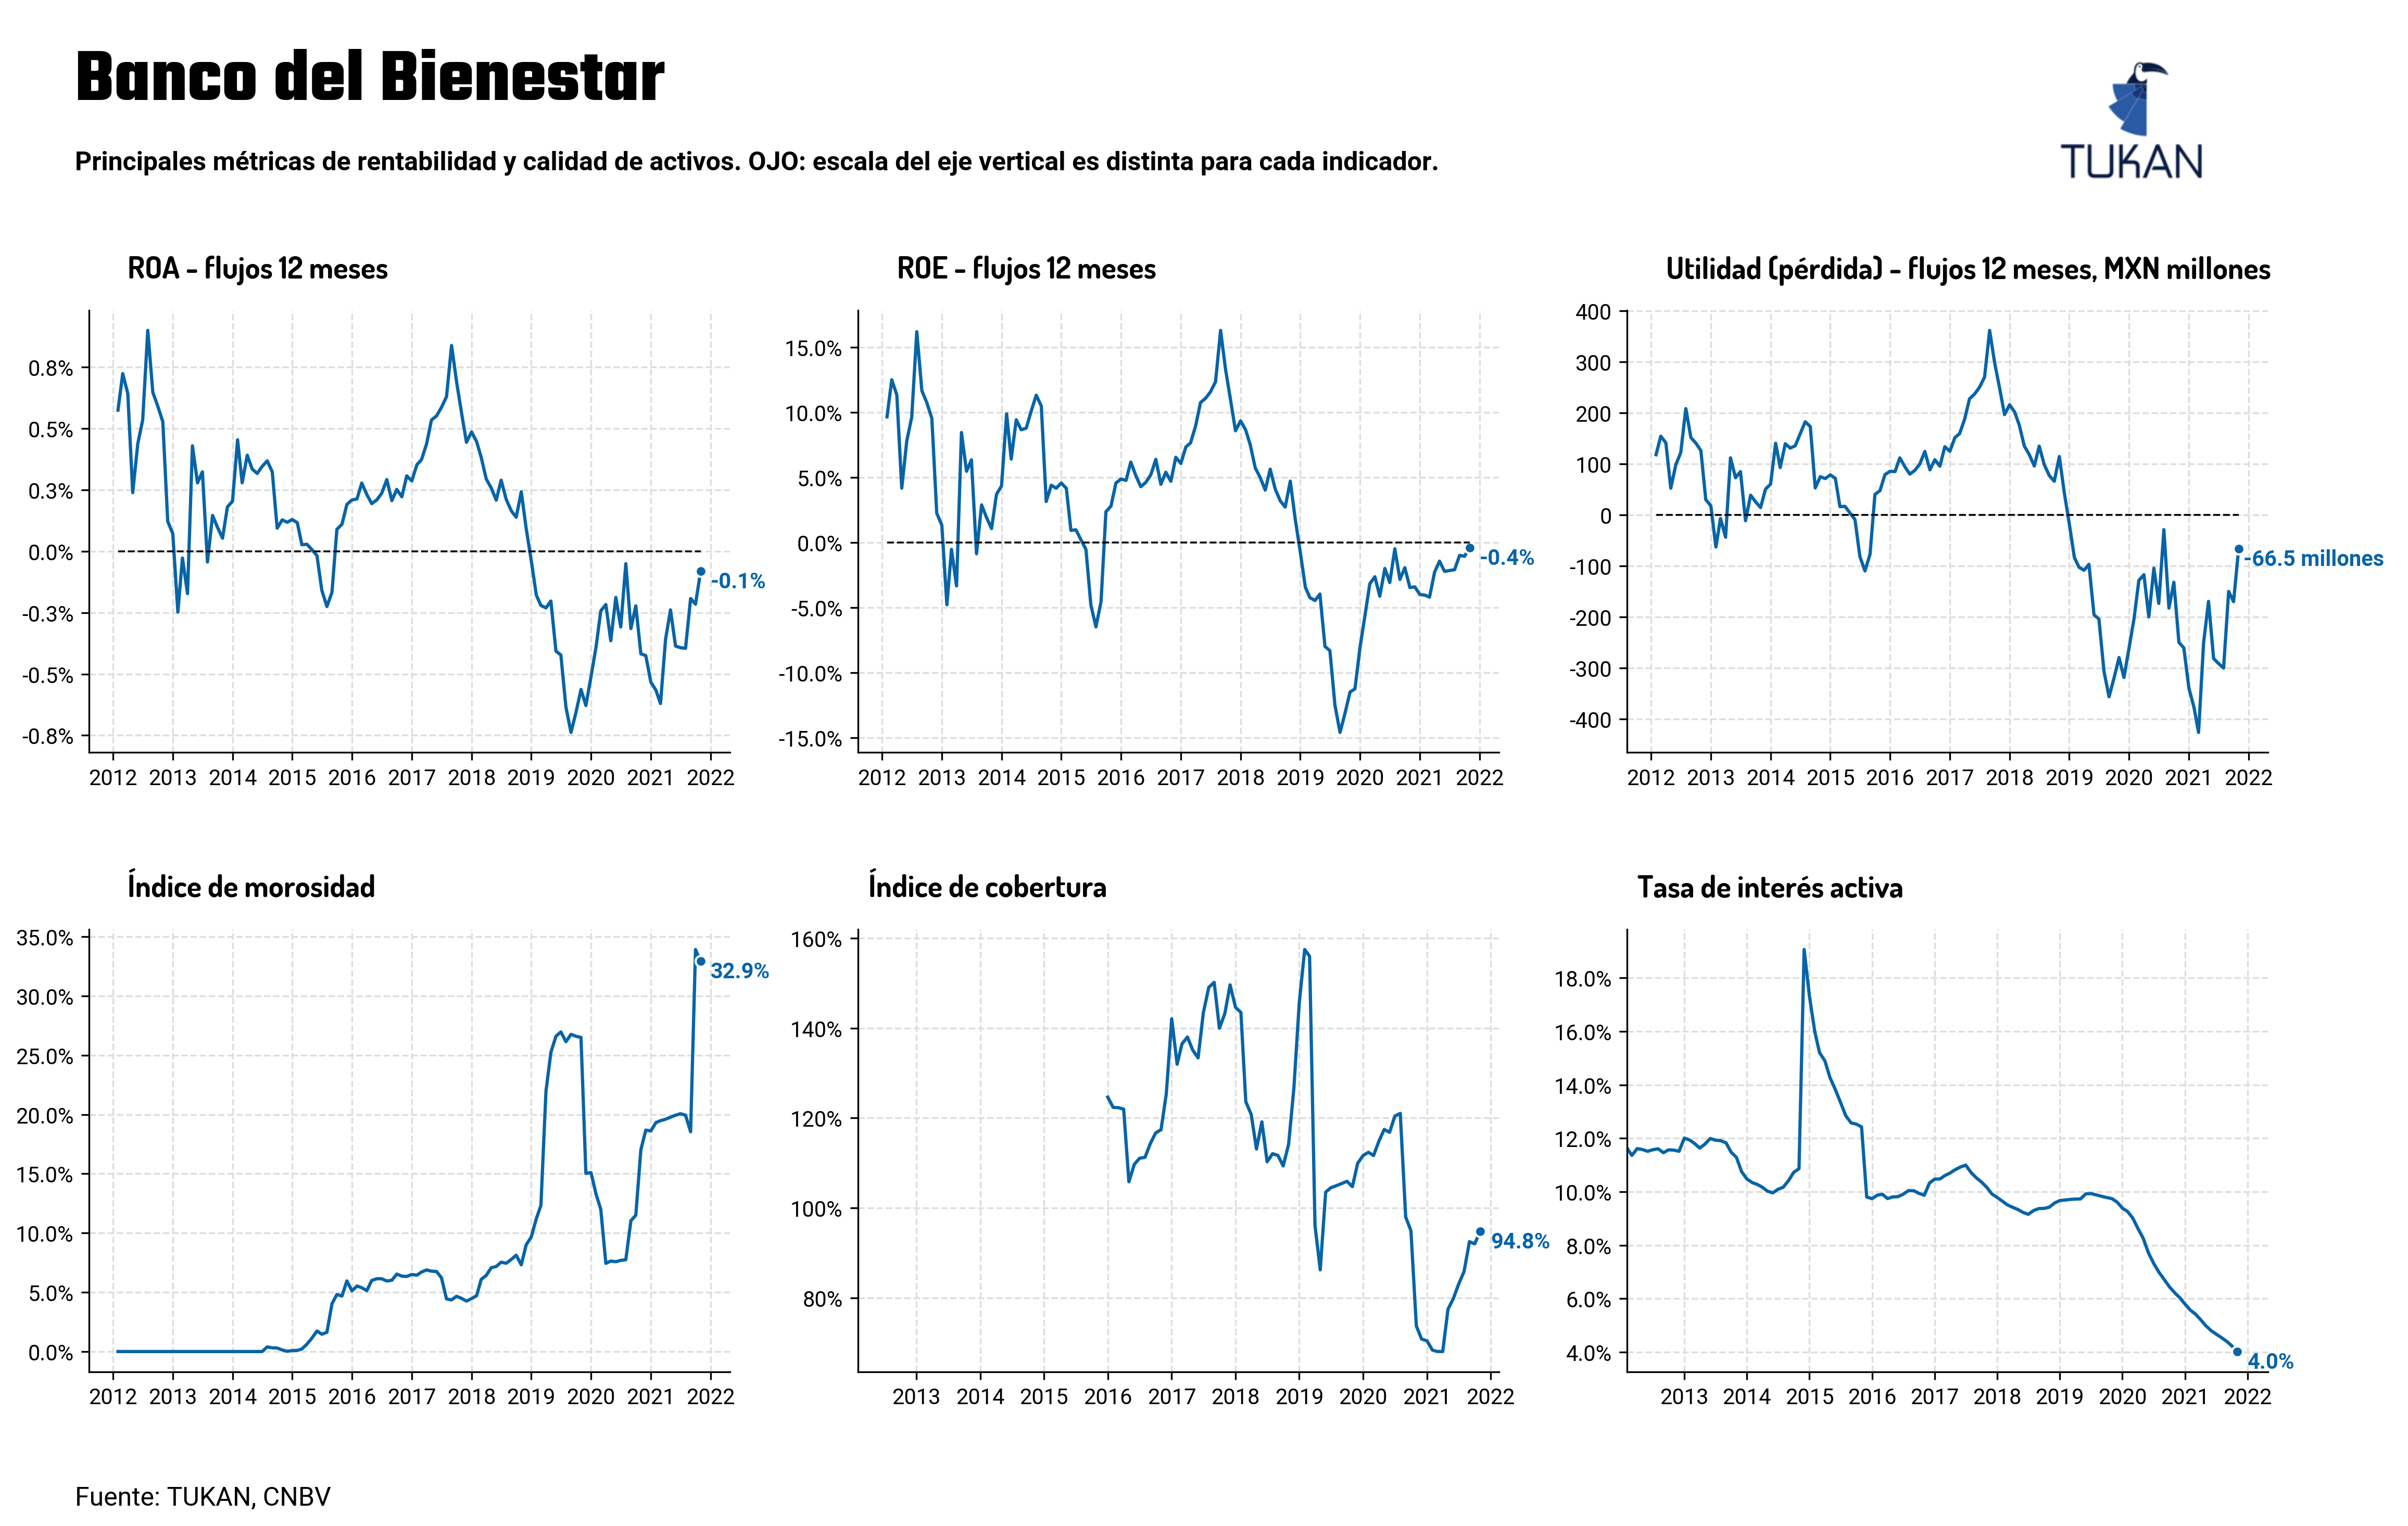

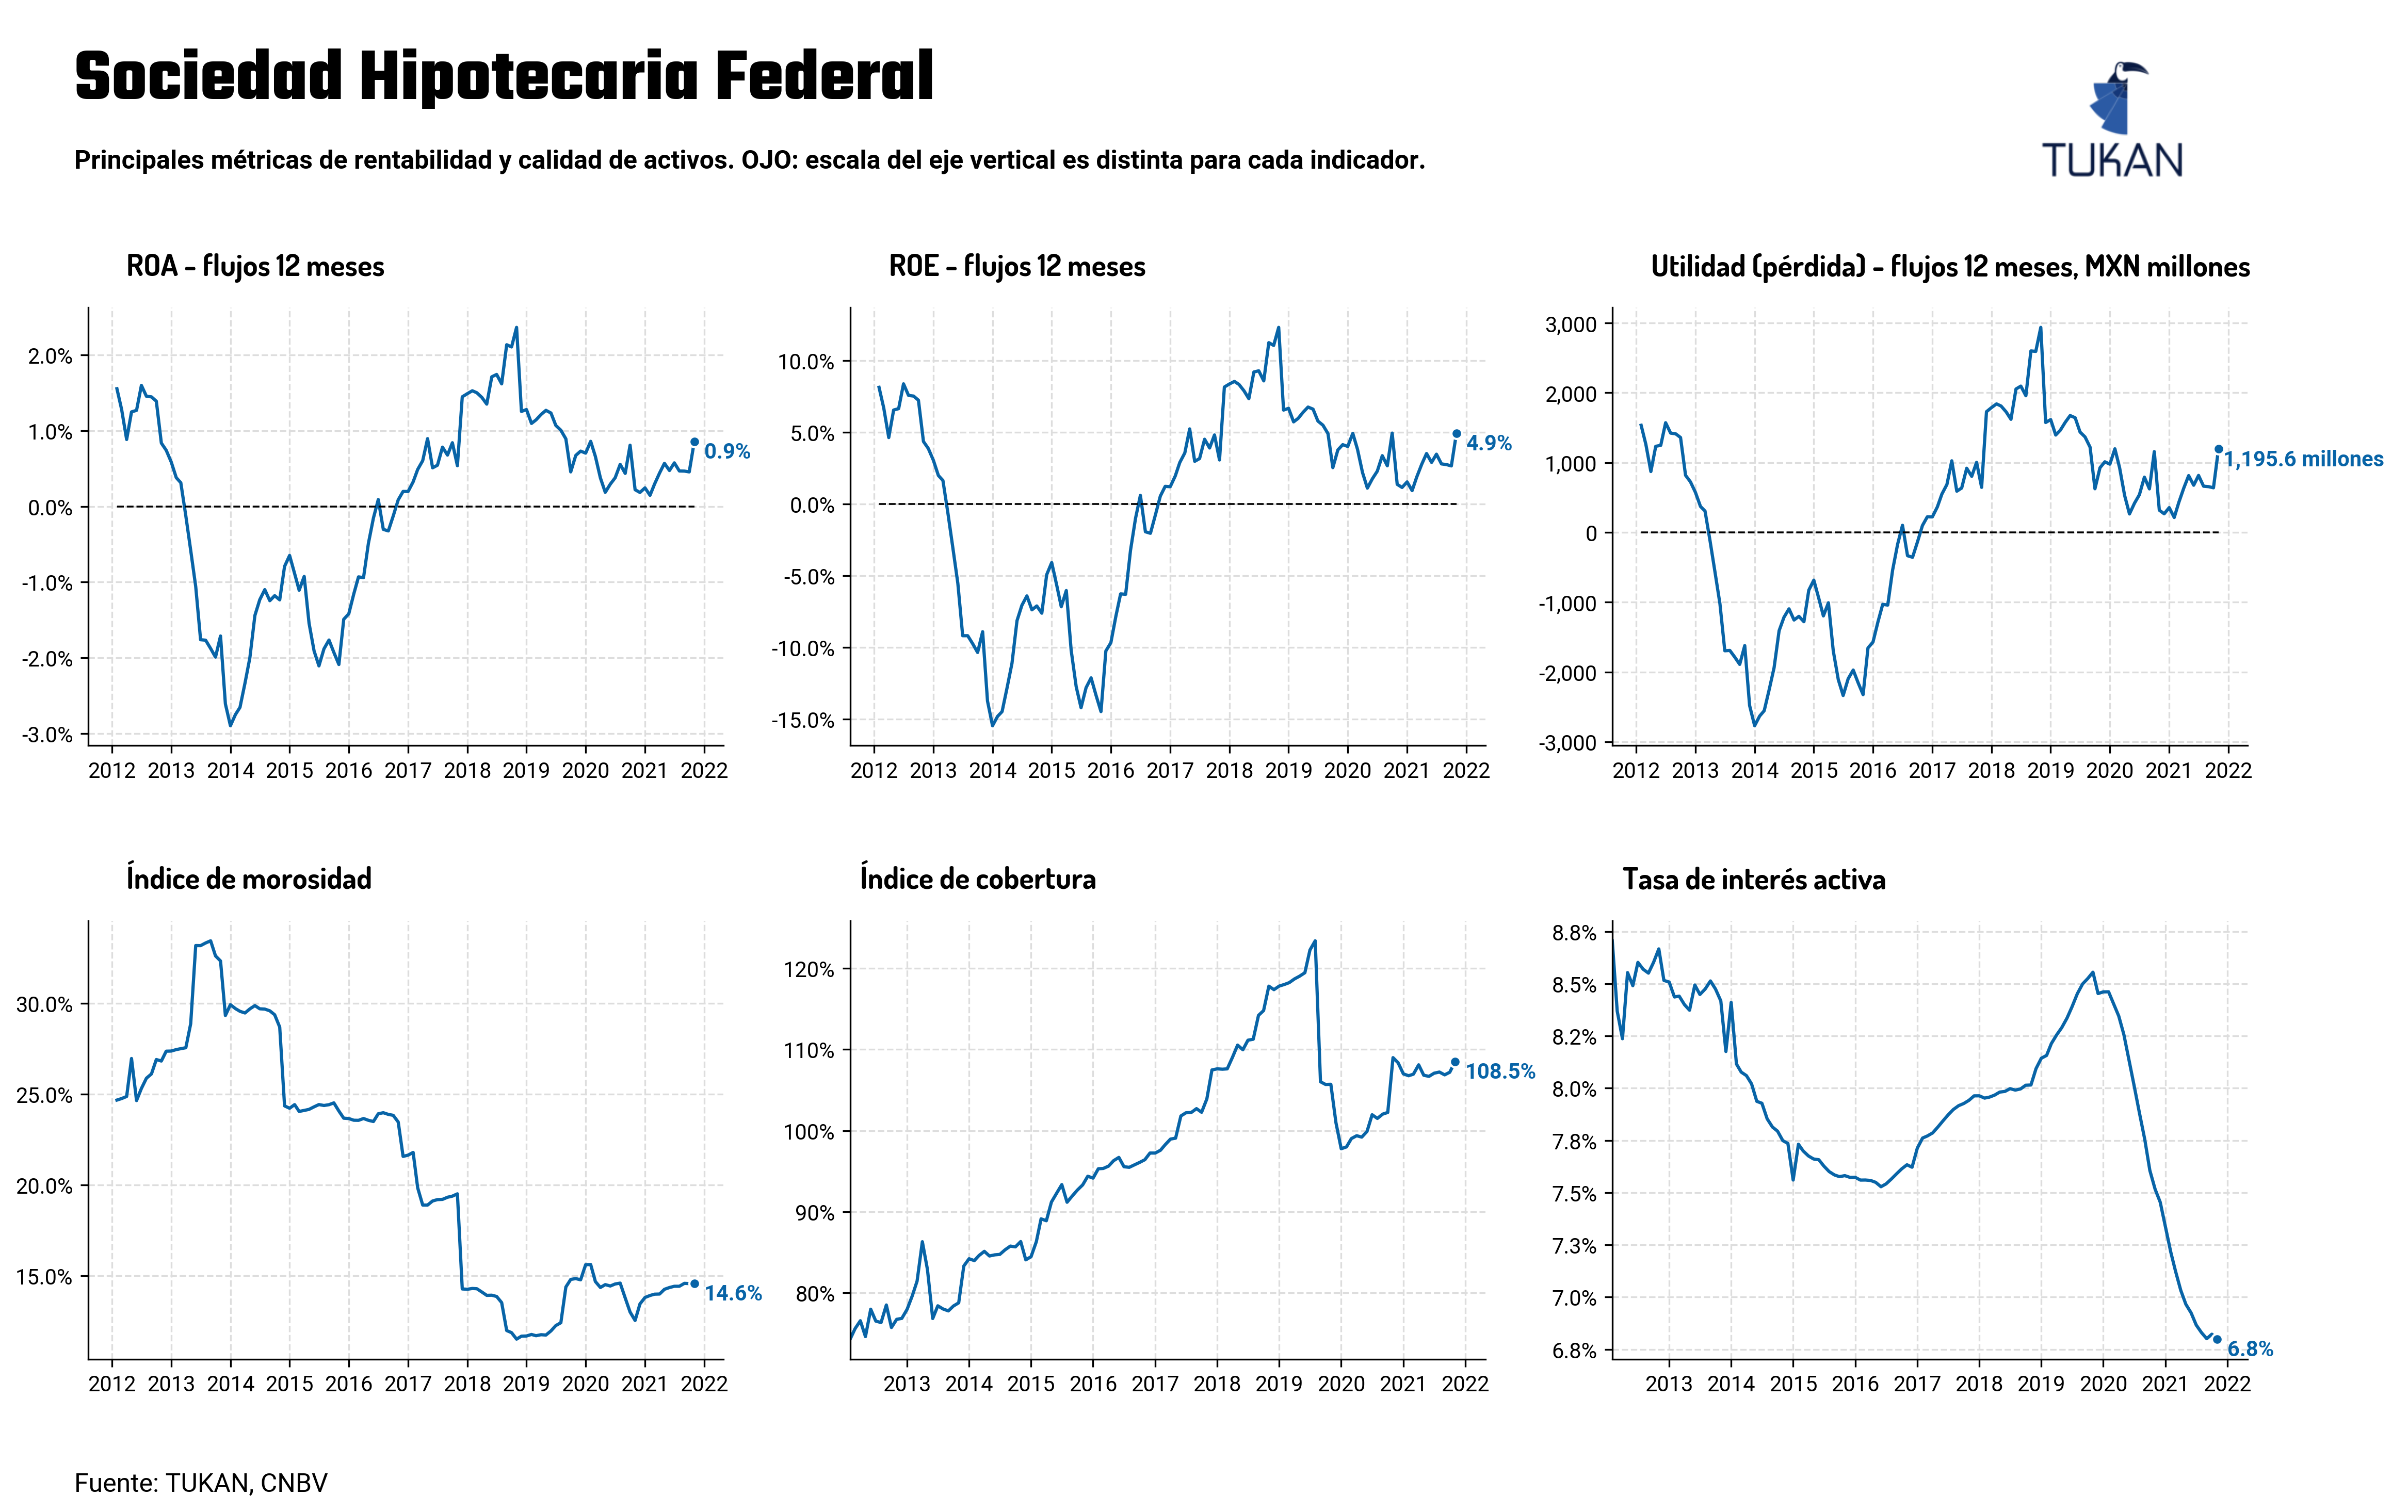

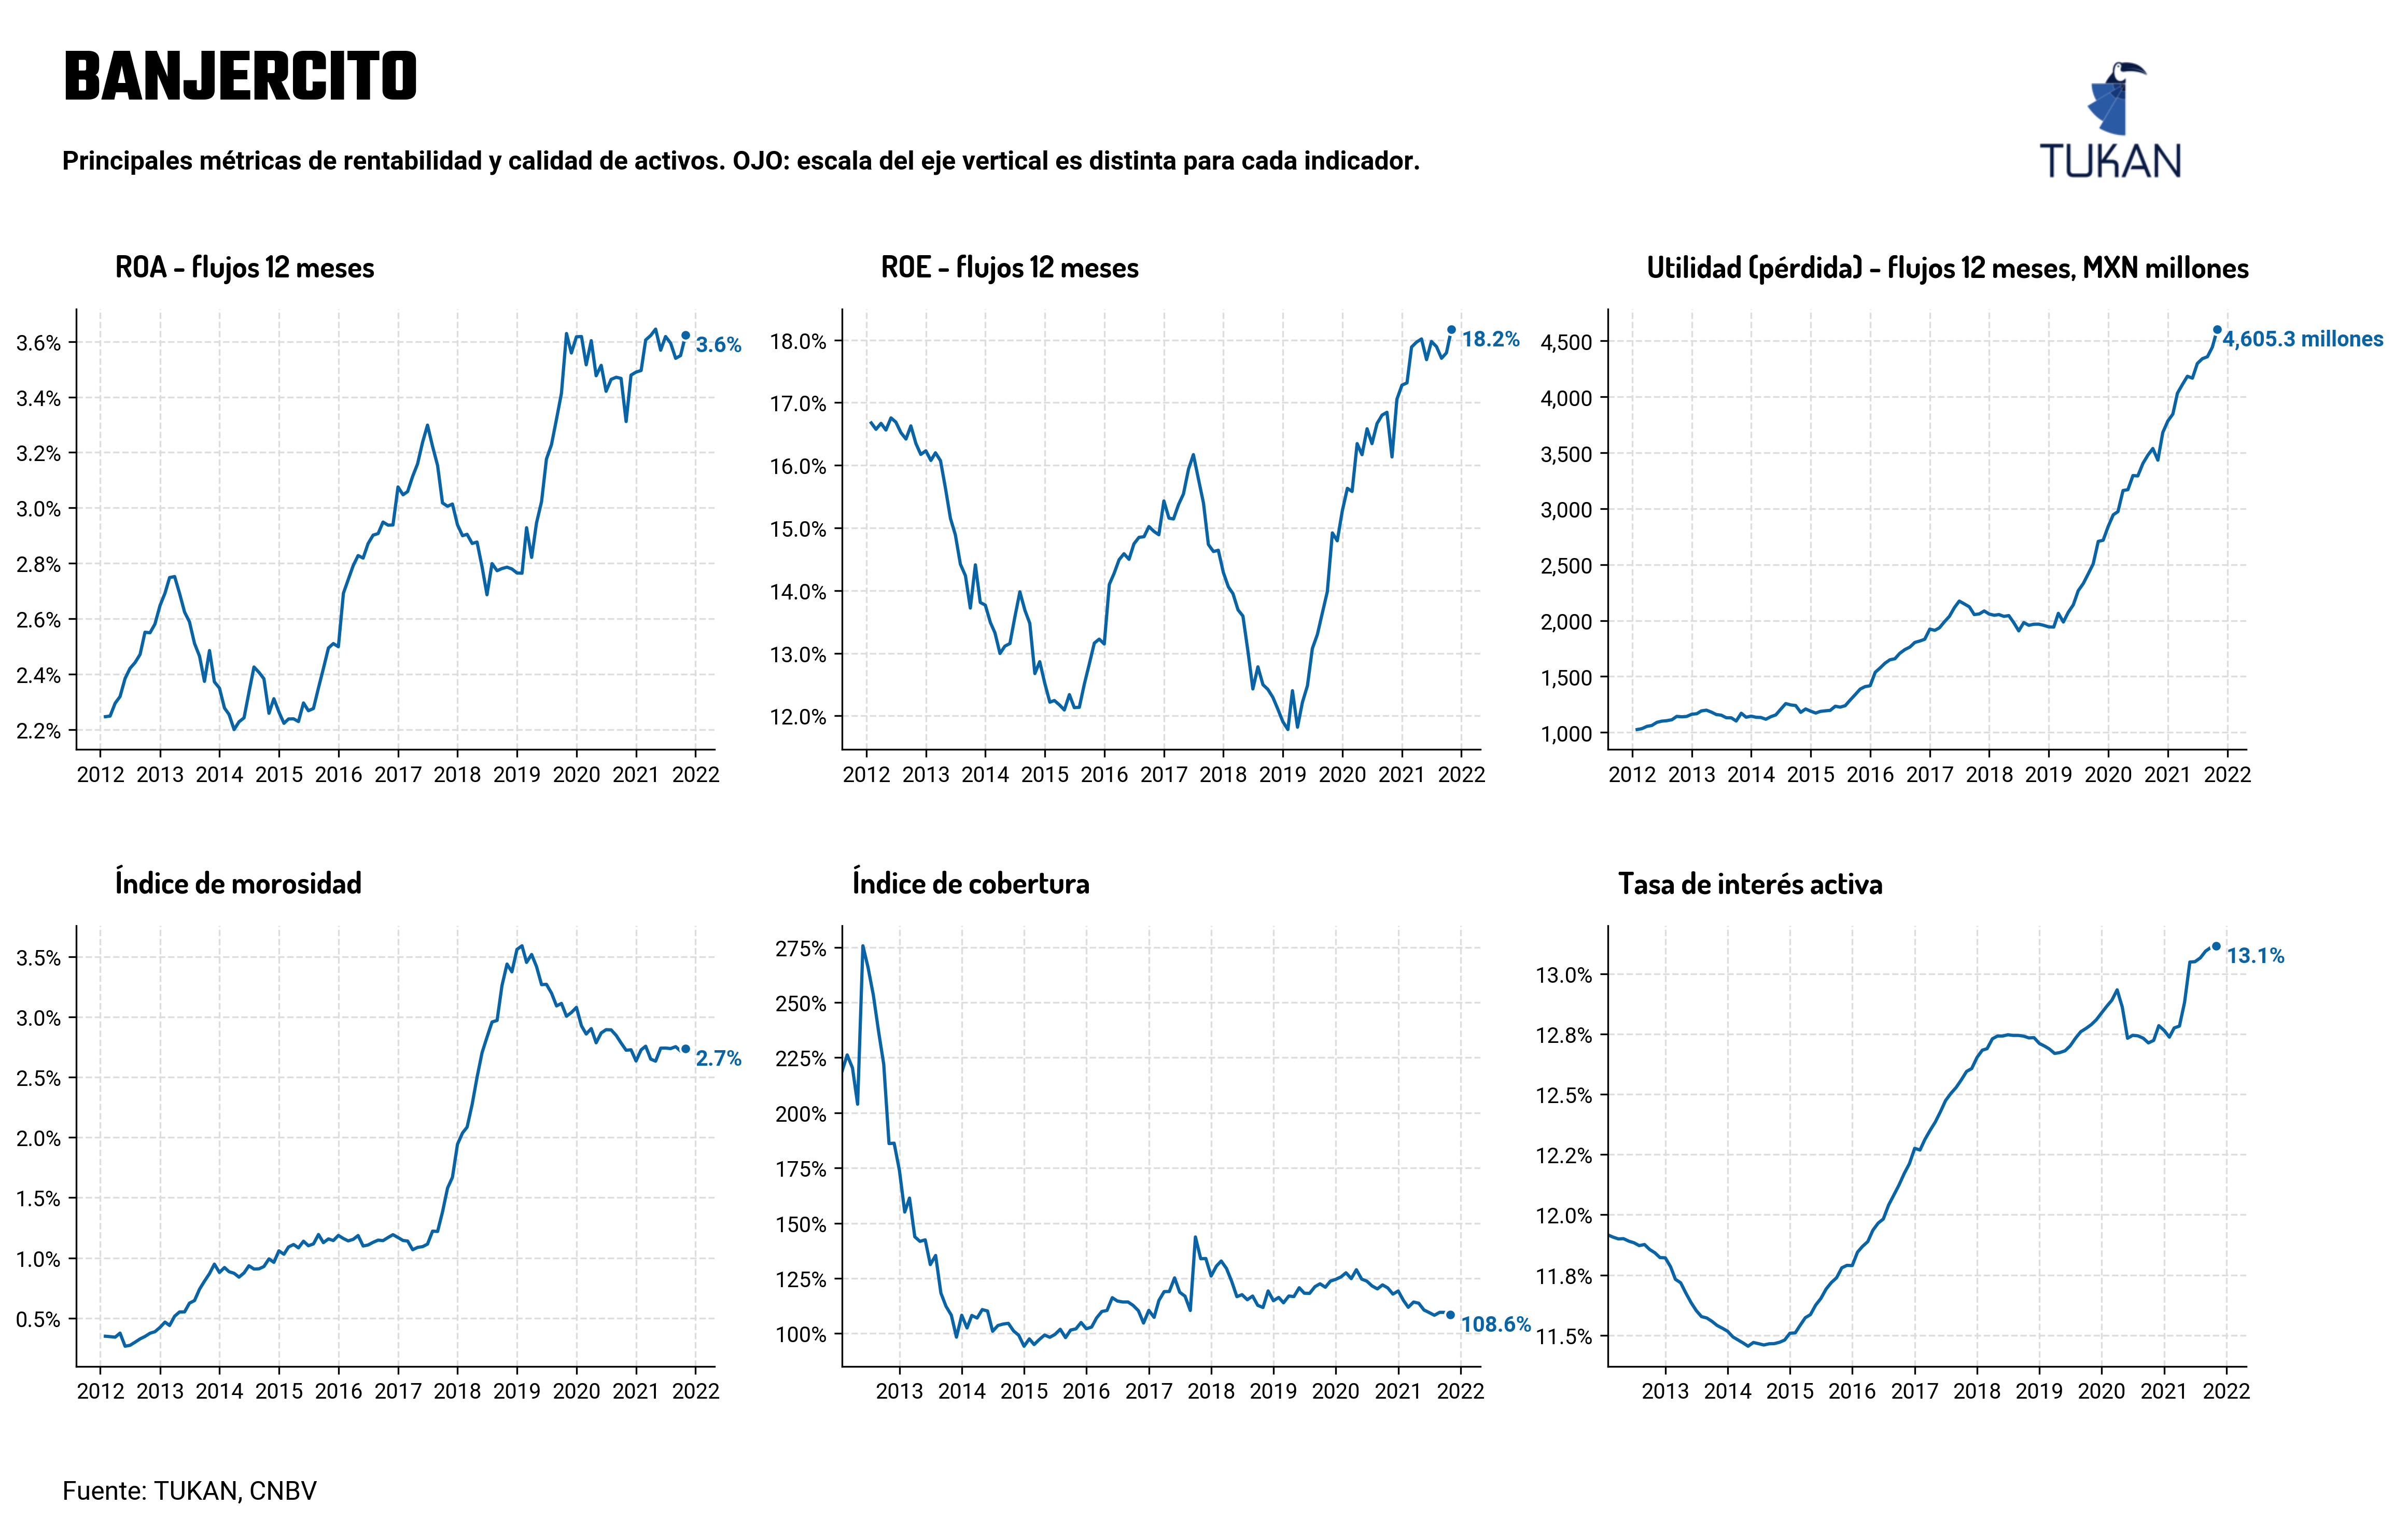

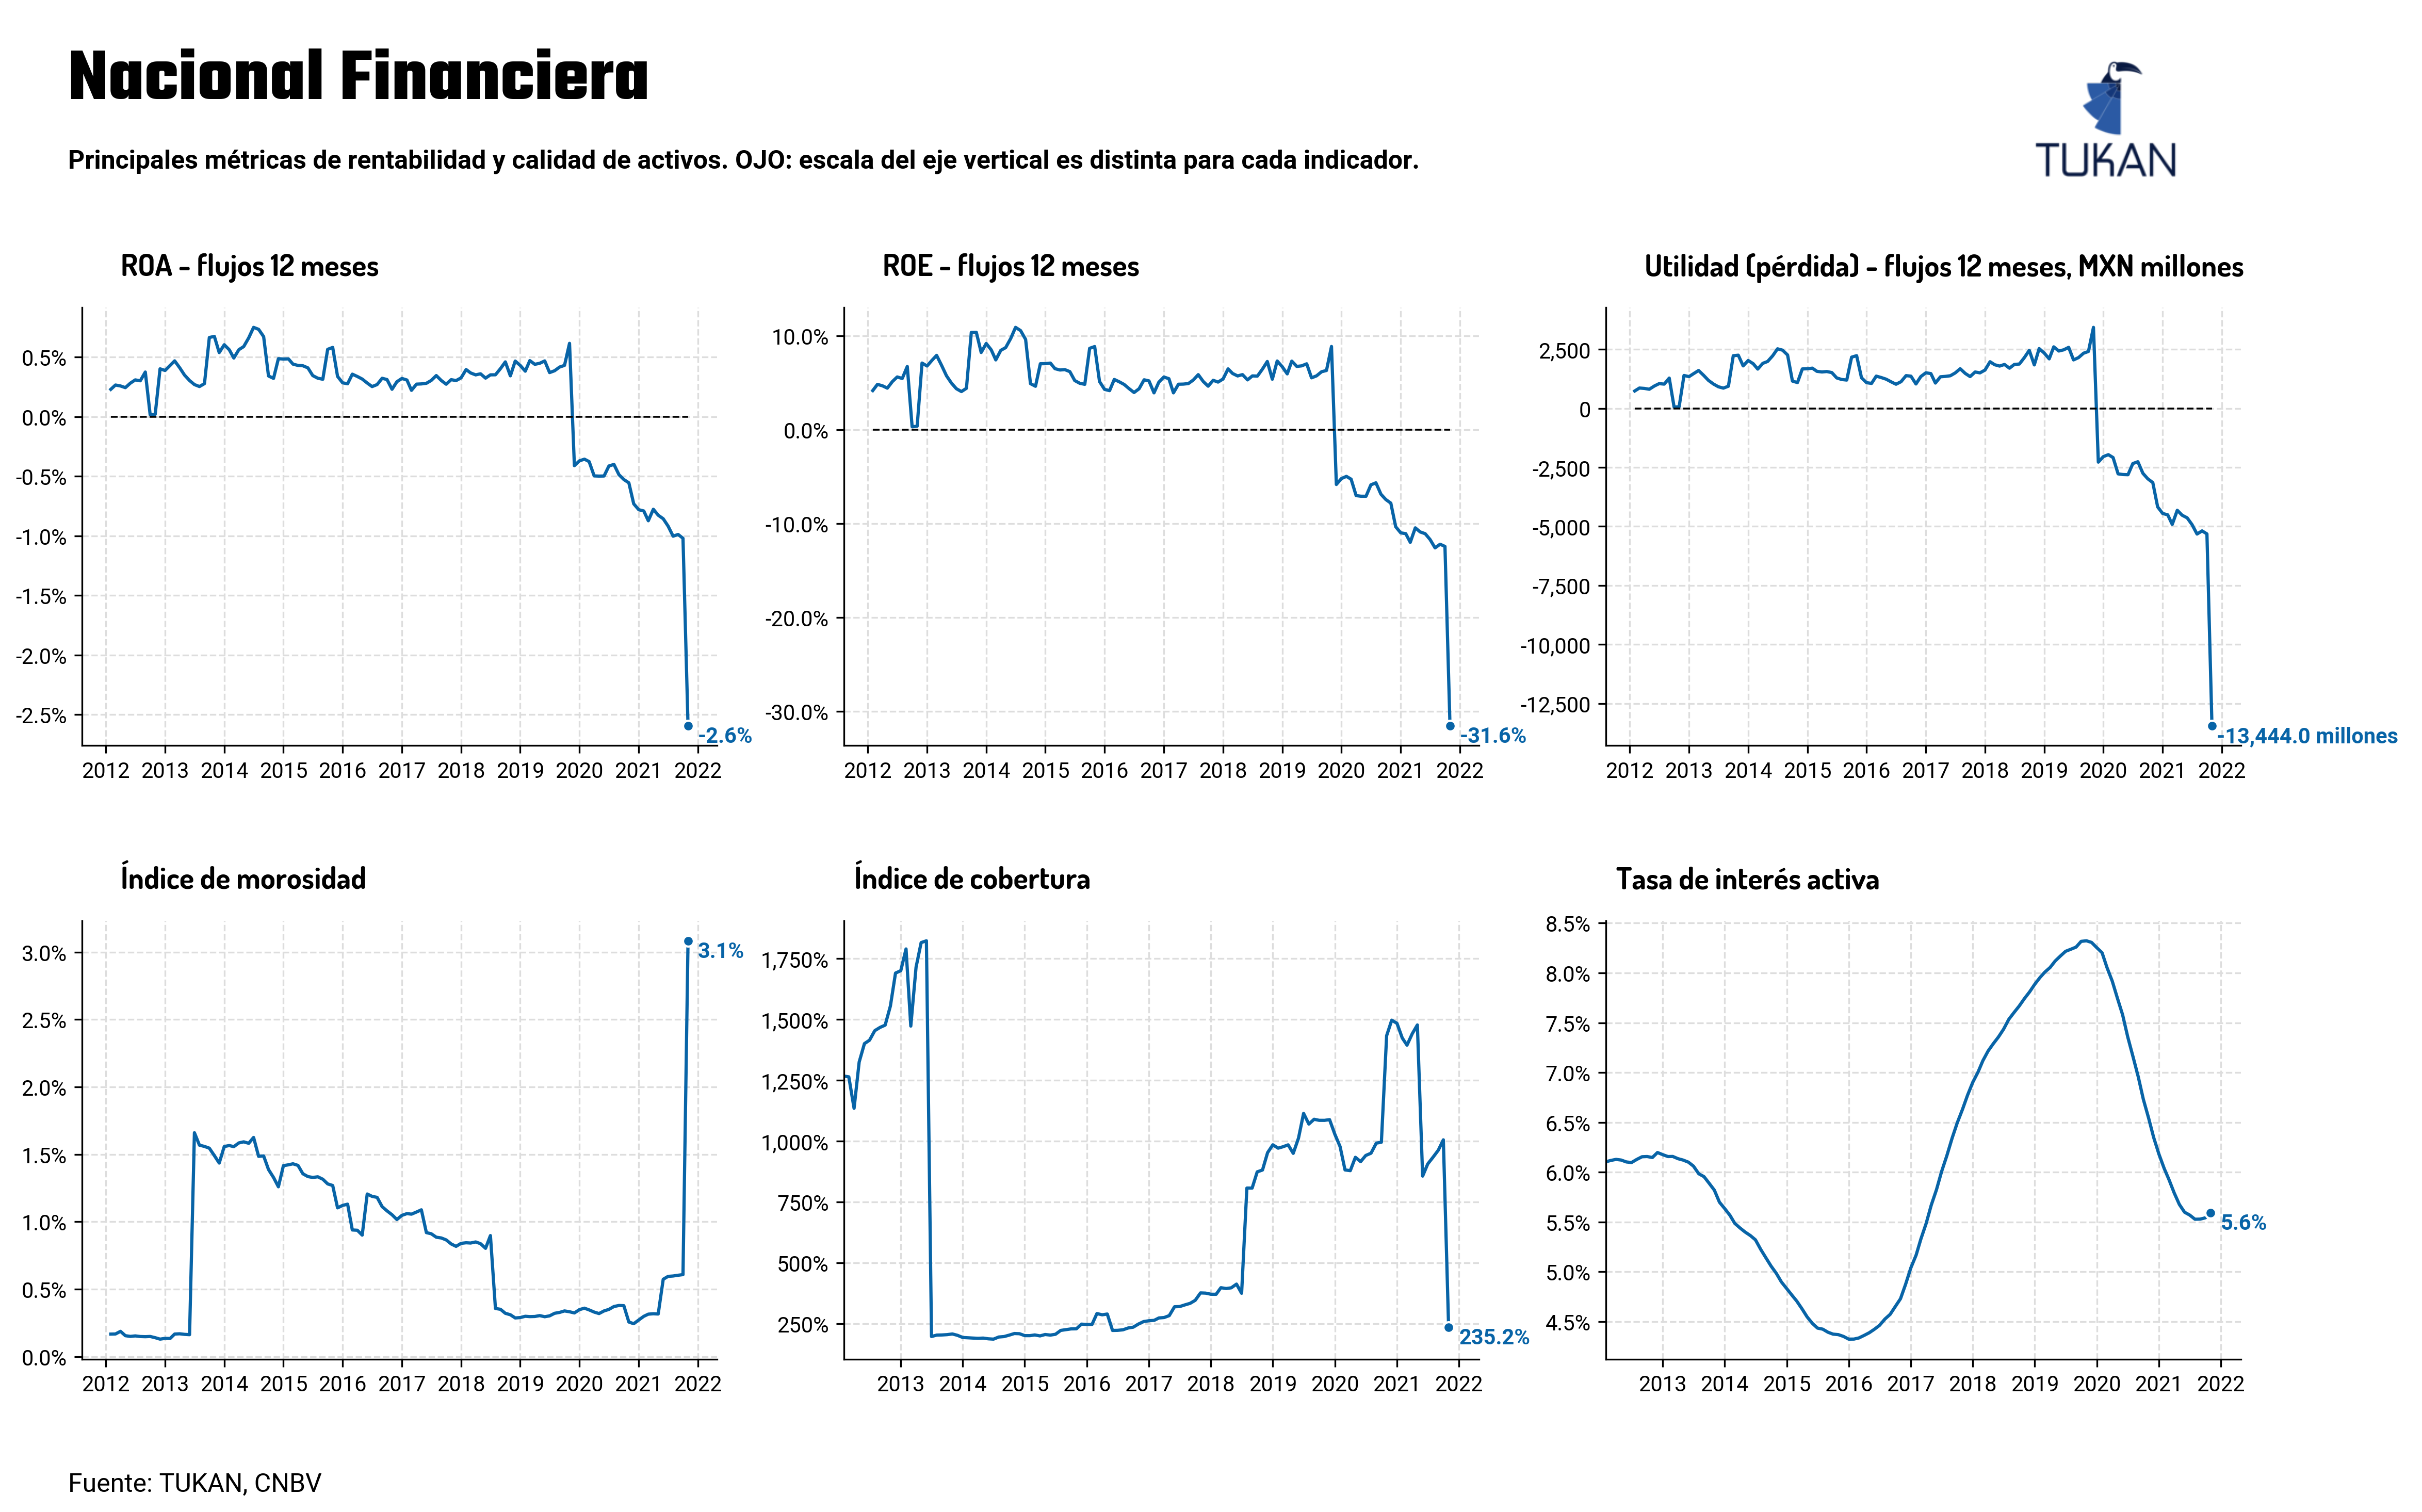

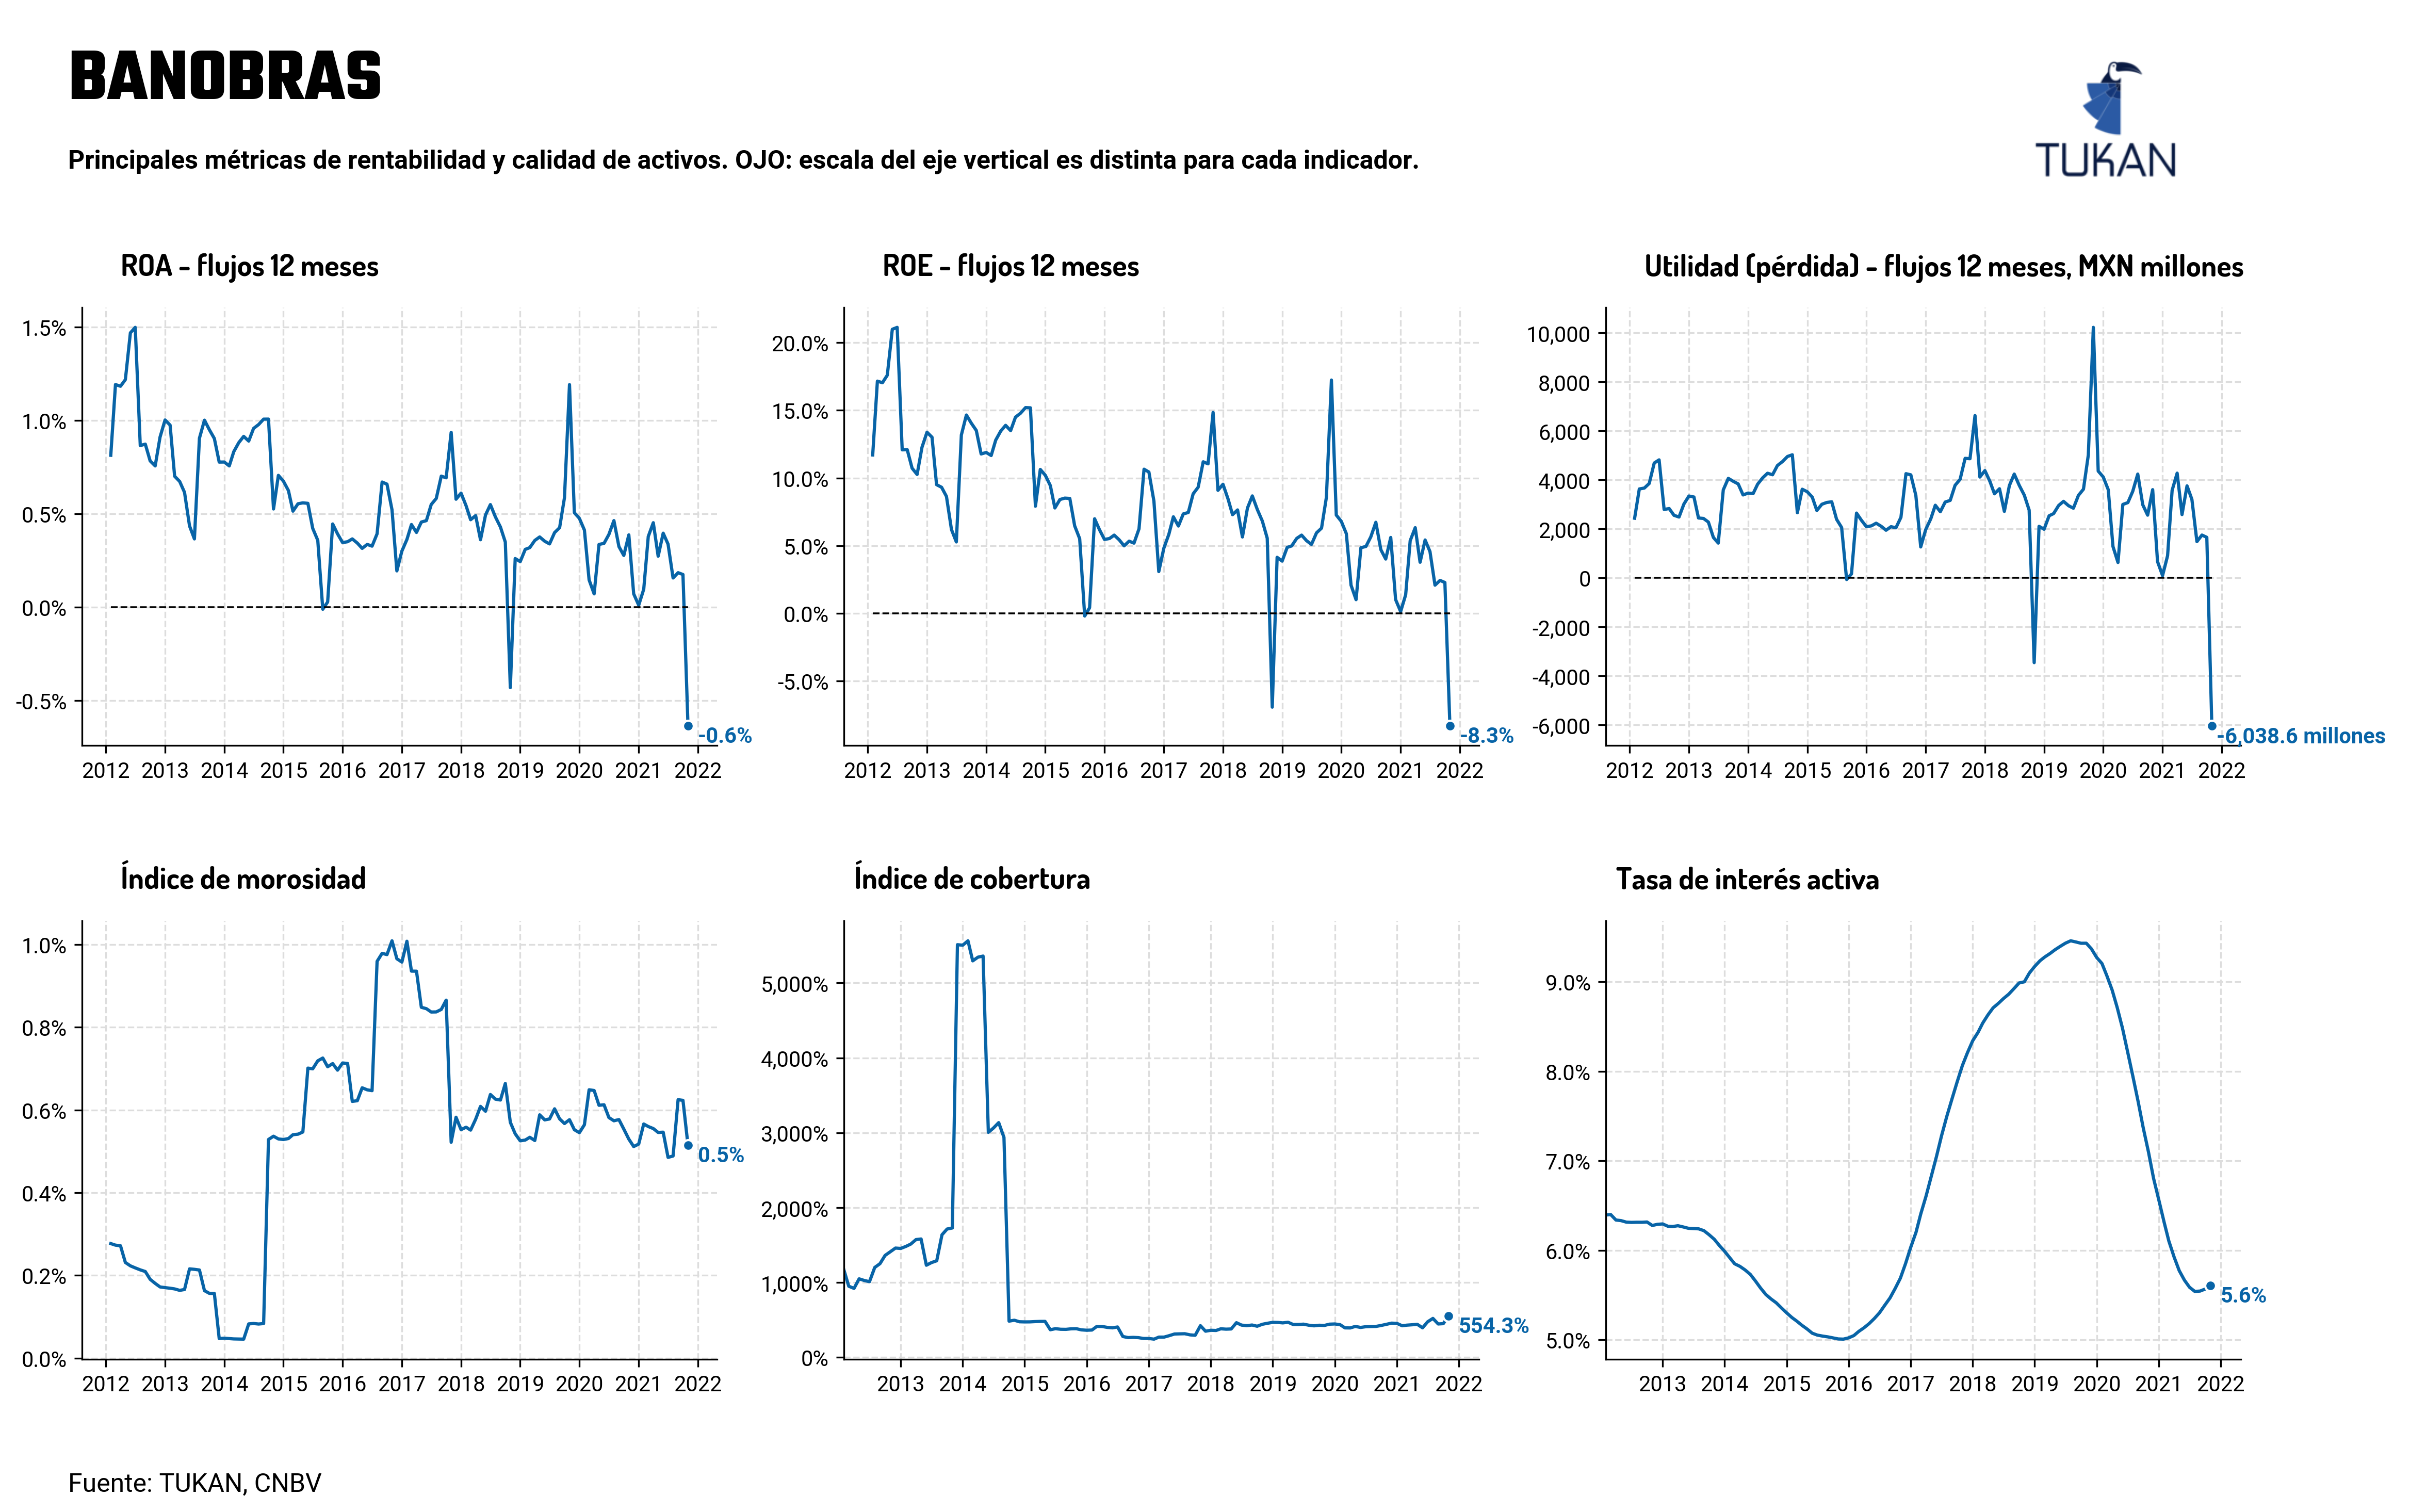

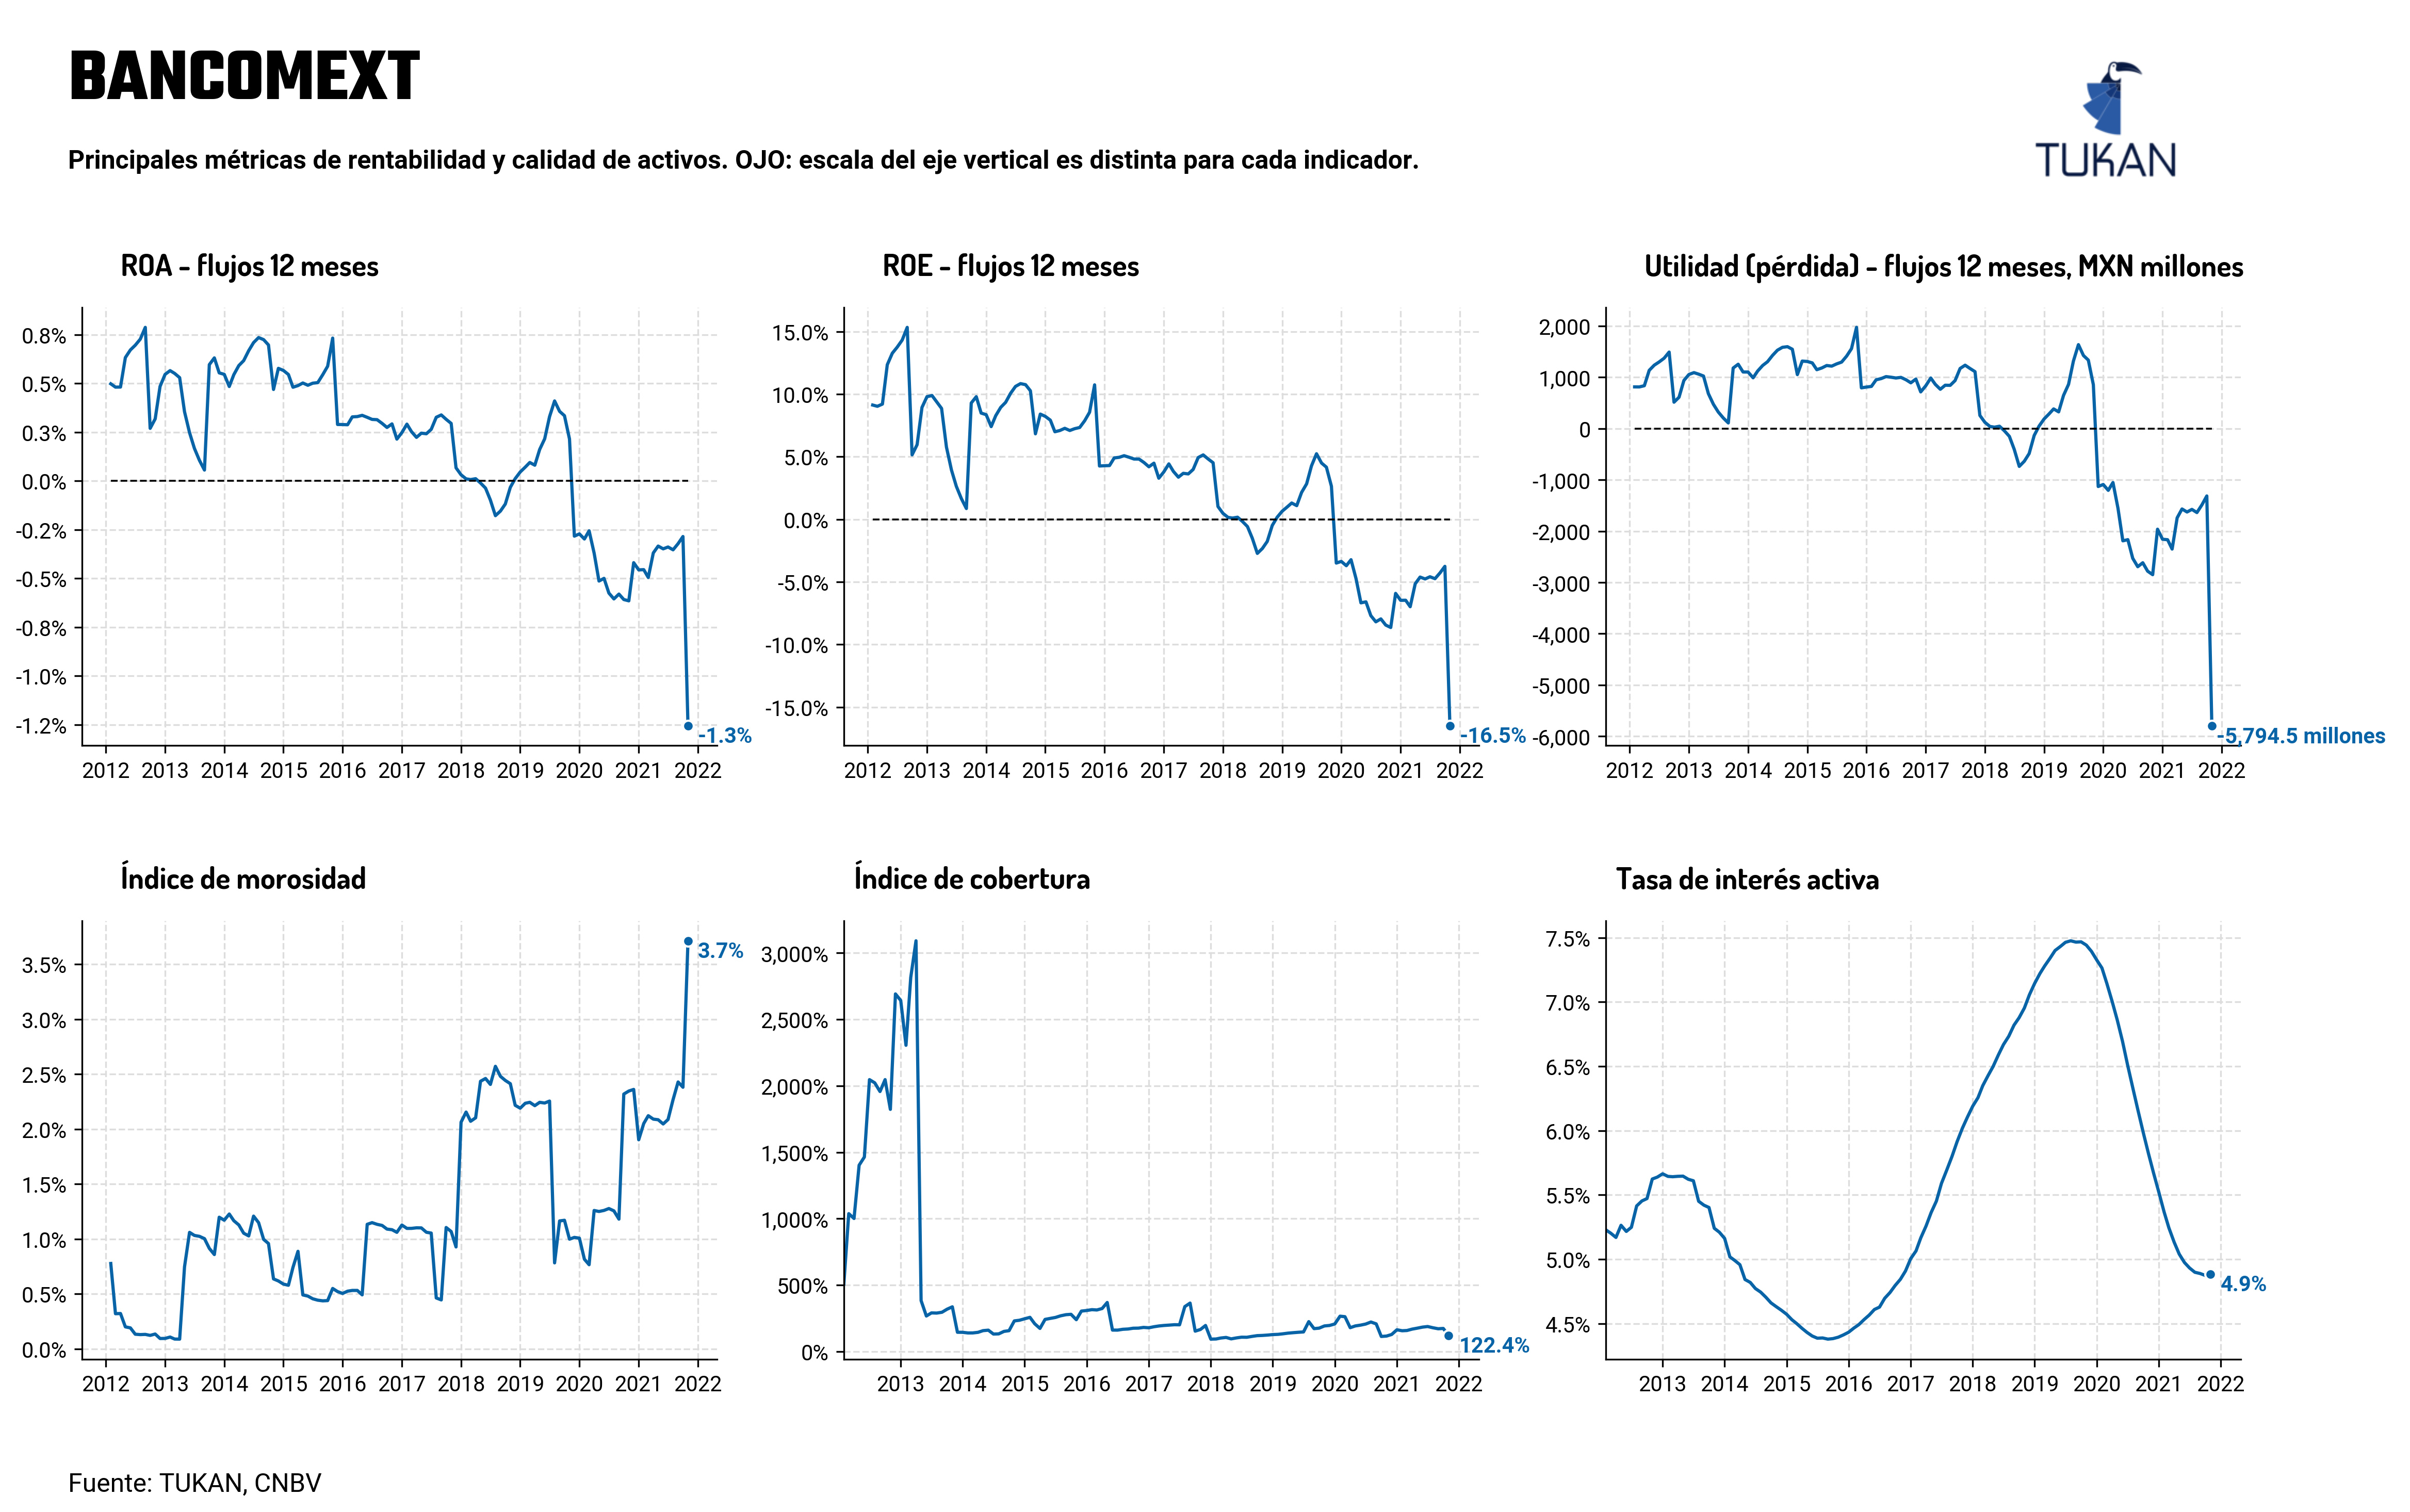

In [36]:
for bank in merged_df["institutions"].unique():

        plot_df = merged_df[merged_df["institutions"] == bank].copy()
        plot_df.reset_index(drop = True, inplace = True)

        fig = plt.figure(figsize=(18,9), dpi = 300)
        gs = fig.add_gridspec(2, 3, hspace = .4)
        axs = gs.subplots(sharex=False, sharey=False)

        # Global parameters
        X_min = plot_df["date"].min()
        X_max = plot_df["date"].max()
        center_date = X_min + ((X_max + relativedelta(months=2)) - X_min)/2
        cmap = mpl.cm.get_cmap("GnBu_r", 10)
        main_color = cmap(1)

        # ROA
        ax_roa = axs[0,0]
        ax_roa.plot(plot_df["date"], plot_df["roa"], color = main_color, marker = "o", markevery = [-1], mec = "white", ms = 5)
        ax_roa.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.1%}"))
        if plot_df["roa"].min() < 0:
                ax_roa.hlines(0, xmin=X_min, xmax = X_max, color = "black", lw = .85, ls = "--")
        Y_end = plot_df["roa"].iloc[-1]
        Y_max = ax_roa.get_ylim()[1] + (ax_roa.get_ylim()[1] - ax_roa.get_ylim()[0])/8
        ax_text(x = X_max + relativedelta(months = 2), y = Y_end,
                s = f"<{Y_end:.1%}>",
                highlight_textprops=[{"color": cmap(1)}], 
                                ax = ax_roa, weight = "bold", font = "Roboto", ha = "left", size = 10)

        ax_text(x = X_min + relativedelta(months = 2), y = Y_max,
                s = f"<ROA - flujos 12 meses>",
                highlight_textprops=[{"color": "black"}], 
                                ax = ax_roa, weight = "bold", font = "Dosis", ha = "left", size = 14)
                        

        # ROE
        ax_roe = axs[0,1]
        ax_roe.plot(plot_df["date"], plot_df["roe"], color = main_color, marker = "o", markevery = [-1], mec = "white", ms = 5)
        ax_roe.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.1%}"))
        if plot_df["roe"].min() < 0:
                ax_roe.hlines(0, xmin=X_min, xmax = X_max, color = "black", lw = .85, ls = "--")
        Y_end = plot_df["roe"].iloc[-1]
        Y_max = ax_roe.get_ylim()[1] + (ax_roe.get_ylim()[1] - ax_roe.get_ylim()[0])/8
        ax_text(x = X_max + relativedelta(months = 2), y = Y_end,
                s = f"<{Y_end:.1%}>",
                highlight_textprops=[{"color": cmap(1)}], 
                                ax = ax_roe, weight = "bold", font = "Roboto", ha = "left", size = 10)

        ax_text(x = X_min + relativedelta(months = 2), y = Y_max,
                s = f"<ROE - flujos 12 meses>",
                highlight_textprops=[{"color": "black"}], 
                                ax = ax_roe, weight = "bold", font = "Dosis", ha = "left", size = 14)

        # LTM - Profit
        ax_ltm_profit = axs[0,2]
        ax_ltm_profit.plot(plot_df["date"], plot_df["ltm_profit"]/1000000, color = main_color, marker = "o", markevery = [-1], mec = "white", ms = 5)
        ax_ltm_profit.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
        if plot_df["ltm_profit"].min() < 0:
                ax_ltm_profit.hlines(0, xmin=X_min, xmax = X_max, color = "black", lw = .85, ls = "--")
        Y_end = plot_df["ltm_profit"].iloc[-1]/1000000
        Y_max = ax_ltm_profit.get_ylim()[1] + (ax_ltm_profit.get_ylim()[1] - ax_ltm_profit.get_ylim()[0])/8
        ax_text(x = X_max + relativedelta(months = 1), y = Y_end,
                s = f"<{Y_end:,.1f} millones>",
                highlight_textprops=[{"color": cmap(1)}], 
                                ax = ax_ltm_profit, weight = "bold", font = "Roboto", ha = "left", size = 10)

        ax_text(x = X_min + relativedelta(months = 2), y = Y_max,
                s = f"<Utilidad (pérdida) - flujos 12 meses, MXN millones>",
                highlight_textprops=[{"color": "black"}], 
                                ax = ax_ltm_profit, weight = "bold", font = "Dosis", ha = "left", size = 14)

        # IMOR
        ax_npl_ratio = axs[1,0]
        ax_npl_ratio.plot(plot_df["date"], plot_df["npl_ratio"], color = main_color, marker = "o", markevery = [-1], mec = "white", ms = 5)
        ax_npl_ratio.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.1%}"))
        Y_end = plot_df["npl_ratio"].iloc[-1]
        Y_max = ax_npl_ratio.get_ylim()[1] + (ax_npl_ratio.get_ylim()[1] - ax_npl_ratio.get_ylim()[0])/8
        ax_text(x = X_max + relativedelta(months = 2), y = Y_end,
                s = f"<{Y_end:.1%}>",
                highlight_textprops=[{"color": cmap(1)}], 
                                ax = ax_npl_ratio, weight = "bold", font = "Roboto", ha = "left", size = 10)

        ax_text(x = X_min + relativedelta(months = 2), y = Y_max,
                s = f"<Índice de morosidad>",
                highlight_textprops=[{"color": "black"}], 
                                ax = ax_npl_ratio, weight = "bold", font = "Dosis", ha = "left", size = 14)

        # ICOR
        ax_icor = axs[1,1]
        if bank == "Banco del Bienestar":
                ax_icor.plot(plot_df[plot_df["date"] > "2015-12-01"]["date"], plot_df[plot_df["date"] > "2015-12-01"]["icor"], color = main_color, marker = "o", markevery = [-1], mec = "white", ms = 5)
        else:
                ax_icor.plot(plot_df["date"], plot_df["icor"], color = main_color, marker = "o", markevery = [-1], mec = "white", ms = 5)
        ax_icor.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0%}"))
        Y_end = plot_df["icor"].iloc[-1]
        Y_max = ax_icor.get_ylim()[1] + (ax_icor.get_ylim()[1] - ax_icor.get_ylim()[0])/8
        ax_icor.set_xlim(X_min)
        ax_text(x = X_max + relativedelta(months = 2), y = Y_end,
                s = f"<{Y_end:.1%}>",
                highlight_textprops=[{"color": cmap(1)}], 
                                ax = ax_icor, weight = "bold", font = "Roboto", ha = "left", size = 10)

        ax_text(x = X_min + relativedelta(months = 2), y = Y_max,
                s = f"<Índice de cobertura>",
                highlight_textprops=[{"color": "black"}], 
                                ax = ax_icor, weight = "bold", font = "Dosis", ha = "left", size = 14)
                
        # Tasa de Interes Activa
        ax_interest_rate = axs[1,2]
        ax_interest_rate.plot(plot_df["date"], plot_df["interest_rate"], color = main_color, marker = "o", markevery = [-1], mec = "white", ms = 5)
        ax_interest_rate.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.1%}"))
        Y_end = plot_df["interest_rate"].iloc[-1]
        Y_max = ax_interest_rate.get_ylim()[1] + (ax_interest_rate.get_ylim()[1] - ax_interest_rate.get_ylim()[0])/8
        ax_interest_rate.set_xlim(X_min)
        ax_text(x = X_max + relativedelta(months = 2), y = Y_end,
                s = f"<{Y_end:.1%}>",
                highlight_textprops=[{"color": cmap(1)}], 
                                ax = ax_interest_rate, weight = "bold", font = "Roboto", ha = "left", size = 10)

        ax_text(x = X_min + relativedelta(months = 2), y = Y_max,
                s = f"<Tasa de interés activa>",
                highlight_textprops=[{"color": "black"}], 
                                ax = ax_interest_rate, weight = "bold", font = "Dosis", ha = "left", size = 14)


        fig.text(
        0.12,
        1.03,
        f"{bank}",
        size=35,
        weight = "bold",
        font = "Teko"
        )

        fig.text(
        0.12,
        .98,
        r"Principales métricas de rentabilidad y calidad de activos. OJO: escala del eje vertical es distinta para cada indicador.",
        size=12,
        weight = "bold"
        )
        # Add footer
        fig.text(0.12, 0.03, "Fuente: TUKAN, CNBV", fontsize=12)

        tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
        newax = fig.add_axes([0.77, .94, 0.12, 0.15], anchor="NE", zorder=1)
        newax.imshow(tukan_im)
        newax.axis("off")

        plt.savefig(
        f"plots/{bank}_ratios_white.png",
        dpi=300,
        bbox_inches="tight",
        edgecolor="none",
        facecolor = "white",
        transparent=False,
        )